# Automatic program Repair (APR)


In [3]:


import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils.simple_metrics import compute_and_store_metrics
from utils.visualization import compare_groundtruth_vs_corrected_histograms, compare_metrics_versus_bug_histograms, plot_column_distribution, plot_metrics_boxplots
from bug_detective.detective import process_prompt_dataset
from data_loader.loader import load_buggy_dataset, load_data, save_data
import numpy as np
import pandas as pd




# Load buggy train dataset
buggy_train_df = load_buggy_dataset('train')

### Experiment Setup

In [8]:
metadata = {
    'sample_size':200,
    'instruction_prompt': "You are a helpful assistant that corrects the code based on the traceback error. You must respect the original code structure and the original code style",
    'random_state': 1,
    'results_filename':'200_metrics_prompt_1.pkl',
    'temperature':0.0,
    'max_tokens':2500
}


In [9]:

prompt_data = buggy_train_df.sample(n=metadata['sample_size'], random_state=metadata['random_state'])
# sample_data = load_data("data_20250703_235942.pkl")
print(f"Sample data shape: {prompt_data.shape}")
print(f"Sample data columns: {prompt_data.columns.tolist()}")

Sample data shape: (200, 16)
Sample data columns: ['after_merge', 'before_merge', 'filename', 'full_file_code_after_merge', 'full_file_code_before_merge', 'function_name', 'url', 'source code and errors', 'full_traceback', 'traceback_type', 'before_merge_without_docstrings', 'after_merge_without_docstrings', 'before_merge_docstrings', 'after_merge_docstrings', 'path_to_snippet_before_merge', 'path_to_snippet_after_merge']


In [10]:
important_columns = ["before_merge_without_docstrings",
                     "after_merge_without_docstrings", "traceback_type", "full_traceback"]
prompt_data = prompt_data.loc[:, [
    col for col in important_columns if col in prompt_data.columns]]
prompt_data.head()

,before_merge_without_docstrings,after_merge_without_docstrings,traceback_type,full_traceback
607122,"def export_outfitting(self, data: Mapping[...","def export_outfitting(self, data: Mapping[...",AttributeError,2020-08-21 13:06:28.140 - DEBUG - plugins.eddn...
271086,"\tdef _create_backup(cls, name,\n ...","\tdef _create_backup(cls, name,\n ...",OSError,"Uploading backup, this can take a while. Pleas..."
280272,"def replace_long_shebang(mode, data):\n if ...","def replace_long_shebang(mode, data):\n if ...",CondaRuntimeError,"Traceback (most recent call last):\nFile ""/Lib..."
230379,"def manifest_analysis(mfxml, man_data_dic):\n ...","def manifest_analysis(mfxml, man_data_dic):\n ...",KeyError,[INFO] 08/Feb/2019 16:17:54 - VM Starting\n[IN...
376072,"def json_normalize(data, record_path=None, met...","def json_normalize(data, record_path=None, met...",IndexError,In[21]: pandas.io.json.json_normalize([])\n---...


4 - fechada pequena, aberta pequena focada em code


In [14]:
from llm_models.open_router import create_openrouter_model

qwen_model = create_openrouter_model(
    model_name="qwen/qwen-2.5-coder-32b-instruct",
    temperature=metadata['temperature'],
    max_tokens=metadata['max_tokens']
)
# gpt_4o_mini_model = create_openrouter_model(
#     model_name="openai/gpt-4o-mini",
#     temperature=0.0,
#     max_tokens=1000
# )
gpt_4o_model = create_openrouter_model(
    model_name="openai/gpt-4o",
    temperature=metadata['temperature'],
    max_tokens=metadata['max_tokens']
)
claude_35_sonnet_model = create_openrouter_model(
    model_name="anthropic/claude-3.5-sonnet",
    temperature=metadata['temperature'],
    max_tokens=metadata['max_tokens']
)

# gemini_2_5_flash_model = create_openrouter_model(
#     model_name="google/gemini-2.5-flash",
#     temperature=0.0,
#     max_tokens=1000
# )

codestral_model = create_openrouter_model(
    model_name="mistralai/codestral-2501",
    temperature=metadata['temperature'],
    max_tokens=metadata['max_tokens']
)
# gpt_4_1_model = create_openrouter_model(
#     model_name="openai/gpt-4.1",
#     temperature=0.0,
#     max_tokens=1000
# )

In [15]:
print(type(prompt_data))
if not isinstance(prompt_data, pd.DataFrame):
    prompt_data = pd.DataFrame(prompt_data)
print(type(prompt_data))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [17]:
import pandas as pd

# Ensure prompt_data is a DataFrame
# if not isinstance(prompt_data, pd.DataFrame):
# prompt_data = pd.DataFrame(prompt_data)

outputs_qwen = await process_prompt_dataset(open_router_model=qwen_model, prompt_dataset=prompt_data, instruction_prompt=metadata['instruction_prompt'])
prompt_data['response_qwen-2.5-coder-32b-instruct'] = outputs_qwen

outputs_gpt_4o = await process_prompt_dataset(open_router_model=gpt_4o_model, prompt_dataset=prompt_data, instruction_prompt=metadata['instruction_prompt'])
prompt_data['response_gpt-4o'] = outputs_gpt_4o

outputs_codestral = await process_prompt_dataset(open_router_model=codestral_model, prompt_dataset=prompt_data, instruction_prompt=metadata['instruction_prompt'])
prompt_data['response_codestral-2501'] = outputs_codestral

outputs_claude_35_sonnet = await process_prompt_dataset(
    open_router_model=claude_35_sonnet_model,
    prompt_dataset=prompt_data,
    instruction_prompt=metadata['instruction_prompt']
)
prompt_data['response_claude-3.5-sonnet'] = outputs_claude_35_sonnet



# outputs_gpt_4_1 = await process_prompt_dataset(gpt_4_1_model, prompt_data,instruction_prompt=instruction_prompt)
# prompt_data['response_gpt-4.1'] = outputs_gpt_4_1

Processing sample 200/200: 100%|█████████████████████████████| 200/200 [25:33<00:00,  7.67s/samples]


In [15]:
prompt_data.columns

Index(['before_merge_without_docstrings', 'after_merge_without_docstrings',
       'traceback_type', 'full_traceback',
       'response_qwen-2.5-coder-32b-instruct', 'response_gpt-4o',
       'response_codestral-2501', 'response_claude-3.5-sonnet',
       'metric_qwen-2.5-coder-32b-instruct_exact_match',
       'metric_qwen-2.5-coder-32b-instruct_ast_score',
       'metric_qwen-2.5-coder-32b-instruct_text_score',
       'metric_qwen-2.5-coder-32b-instruct_ast_score_normalized',
       'metric_qwen-2.5-coder-32b-instruct_codebleu',
       'metric_qwen-2.5-coder-32b-instruct_ngram_match_score',
       'metric_qwen-2.5-coder-32b-instruct_weighted_ngram_match_score',
       'metric_qwen-2.5-coder-32b-instruct_syntax_match_score',
       'metric_qwen-2.5-coder-32b-instruct_dataflow_match_score',
       'metric_gpt-4o_exact_match', 'metric_gpt-4o_ast_score',
       'metric_gpt-4o_text_score', 'metric_gpt-4o_ast_score_normalized',
       'metric_gpt-4o_codebleu', 'metric_gpt-4o_ngram_match_sc

In [18]:
from Bugdetectiveai.scr.utils.visualization import create_metrics_summary_table
prompt_data = compute_and_store_metrics(prompt_data)
# Create summary table for prompt metrics
response_columns_prompt = [col for col in prompt_data.columns if "response" in col]
summary_table_prompt_200 = create_metrics_summary_table(prompt_data, response_columns_prompt)

Computing metrics for after_merge_without_docstrings vs 4 response columns...
Processing response_qwen-2.5-coder-32b-instruct...


Computing response_qwen-2.5-coder-32b-instruct: 100%|██████████| 200/200 [00:16<00:00, 12.04it/s]


  Added 9 metric columns for response_qwen-2.5-coder-32b-instruct
Processing response_gpt-4o...


Computing response_gpt-4o: 100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


  Added 9 metric columns for response_gpt-4o
Processing response_codestral-2501...


Computing response_codestral-2501: 100%|██████████| 200/200 [00:15<00:00, 12.69it/s]


  Added 9 metric columns for response_codestral-2501
Processing response_claude-3.5-sonnet...


Computing response_claude-3.5-sonnet: 100%|██████████| 200/200 [00:09<00:00, 21.70it/s]

  Added 9 metric columns for response_claude-3.5-sonnet
Completed! Added metrics for 4 response columns.
Creating metrics summary table for 4 response columns...

=== Metrics Summary Table ===
Models: 4
Metrics: 9
Statistics shown: mean ± std
Sample counts shown in parentheses

                                       exact_match              ast_score             text_score   ast_score_normalized               codebleu      ngram_match_score weighted_ngram_match_score     syntax_match_score   dataflow_match_score
Qwen-2.5-Coder-32B-Instruct  0.010 ± 0.100 (n=200)  0.211 ± 0.385 (n=200)  0.816 ± 0.210 (n=200)  0.257 ± 0.408 (n=200)  0.790 ± 0.182 (n=200)  0.748 ± 0.241 (n=200)      0.793 ± 0.216 (n=200)  0.819 ± 0.170 (n=200)  0.756 ± 0.262 (n=200)
Gpt-4O                       0.010 ± 0.100 (n=200)  0.202 ± 0.373 (n=200)  0.734 ± 0.222 (n=200)  0.196 ± 0.362 (n=200)  0.771 ± 0.198 (n=200)  0.714 ± 0.257 (n=200)      0.778 ± 0.237 (n=200)  0.804 ± 0.193 (n=200)  0.729 ± 0.273 (n=200)
Code

In [21]:
save_data(prompt_data,metadata['results_filename'])

Data saved to: /Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/200_metrics_prompt_1.pkl


'/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/200_metrics_prompt_1.pkl'

In [ ]:
import json
import os
from pathlib import Path

def save_metadata(
    metadata: dict,
    file_name: str = "metadata.json",
    data_path: str = "/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/",
    override: bool = False
) -> str:
    """
    Save a metadata dictionary as a JSON file in the specified directory.

    Args:
        metadata (dict): The metadata to save.
        file_name (str): The name of the JSON file (default: "metadata.json").
        data_path (str): The directory to save the file (default: checkpoints path).
        override (bool): If True, override existing file. If False and file exists, raise an error.

    Returns:
        str: The full path to the saved JSON file.

    Raises:
        FileExistsError: If the file already exists and override is False.
    """
    # Ensure .json extension
    if not file_name.endswith(".json"):
        file_name += ".json"
    # Create directory if it doesn't exist
    Path(data_path).mkdir(parents=True, exist_ok=True)
    file_path = os.path.join(data_path, file_name)
    if os.path.exists(file_path) and not override:
        raise FileExistsError(f"File '{file_path}' already exists. Set override=True to overwrite.")
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)
    return file_path
save_metadata(metadata,'metadata_' + metadata['results_filename'])

### Save data


In [ ]:
# import pickle
# import pandas as pd
# from datetime import datetime
# from pathlib import Path
# import os

# data_path = '/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints'

# # Get number of rows
# num_rows = len(sample_data)

# # Get all response columns
# response_columns = [col for col in sample_data.columns if "response_" in col]
# response_names = "_".join([col.replace("response_", "") for col in response_columns])

# # Compose file name
# file_name = f"sample_data_{num_rows}_rows_{response_names}.pkl"
# file_path = os.path.join(data_path, file_name)

# Path(data_path).mkdir(parents=True, exist_ok=True)
# with open(file_path, 'wb') as f:
#     pickle.dump(sample_data, f)
# print(f"Data saved to: {file_path}")

### Load Data


In [19]:
save_data(prompt_data,"200_metrics_prompt_1.pkl")

Data saved to: /Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/200_metrics_prompt_1.pkl


'/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/200_metrics_prompt_1.pkl'

Creating boxplots using stored metrics for 4 response columns...


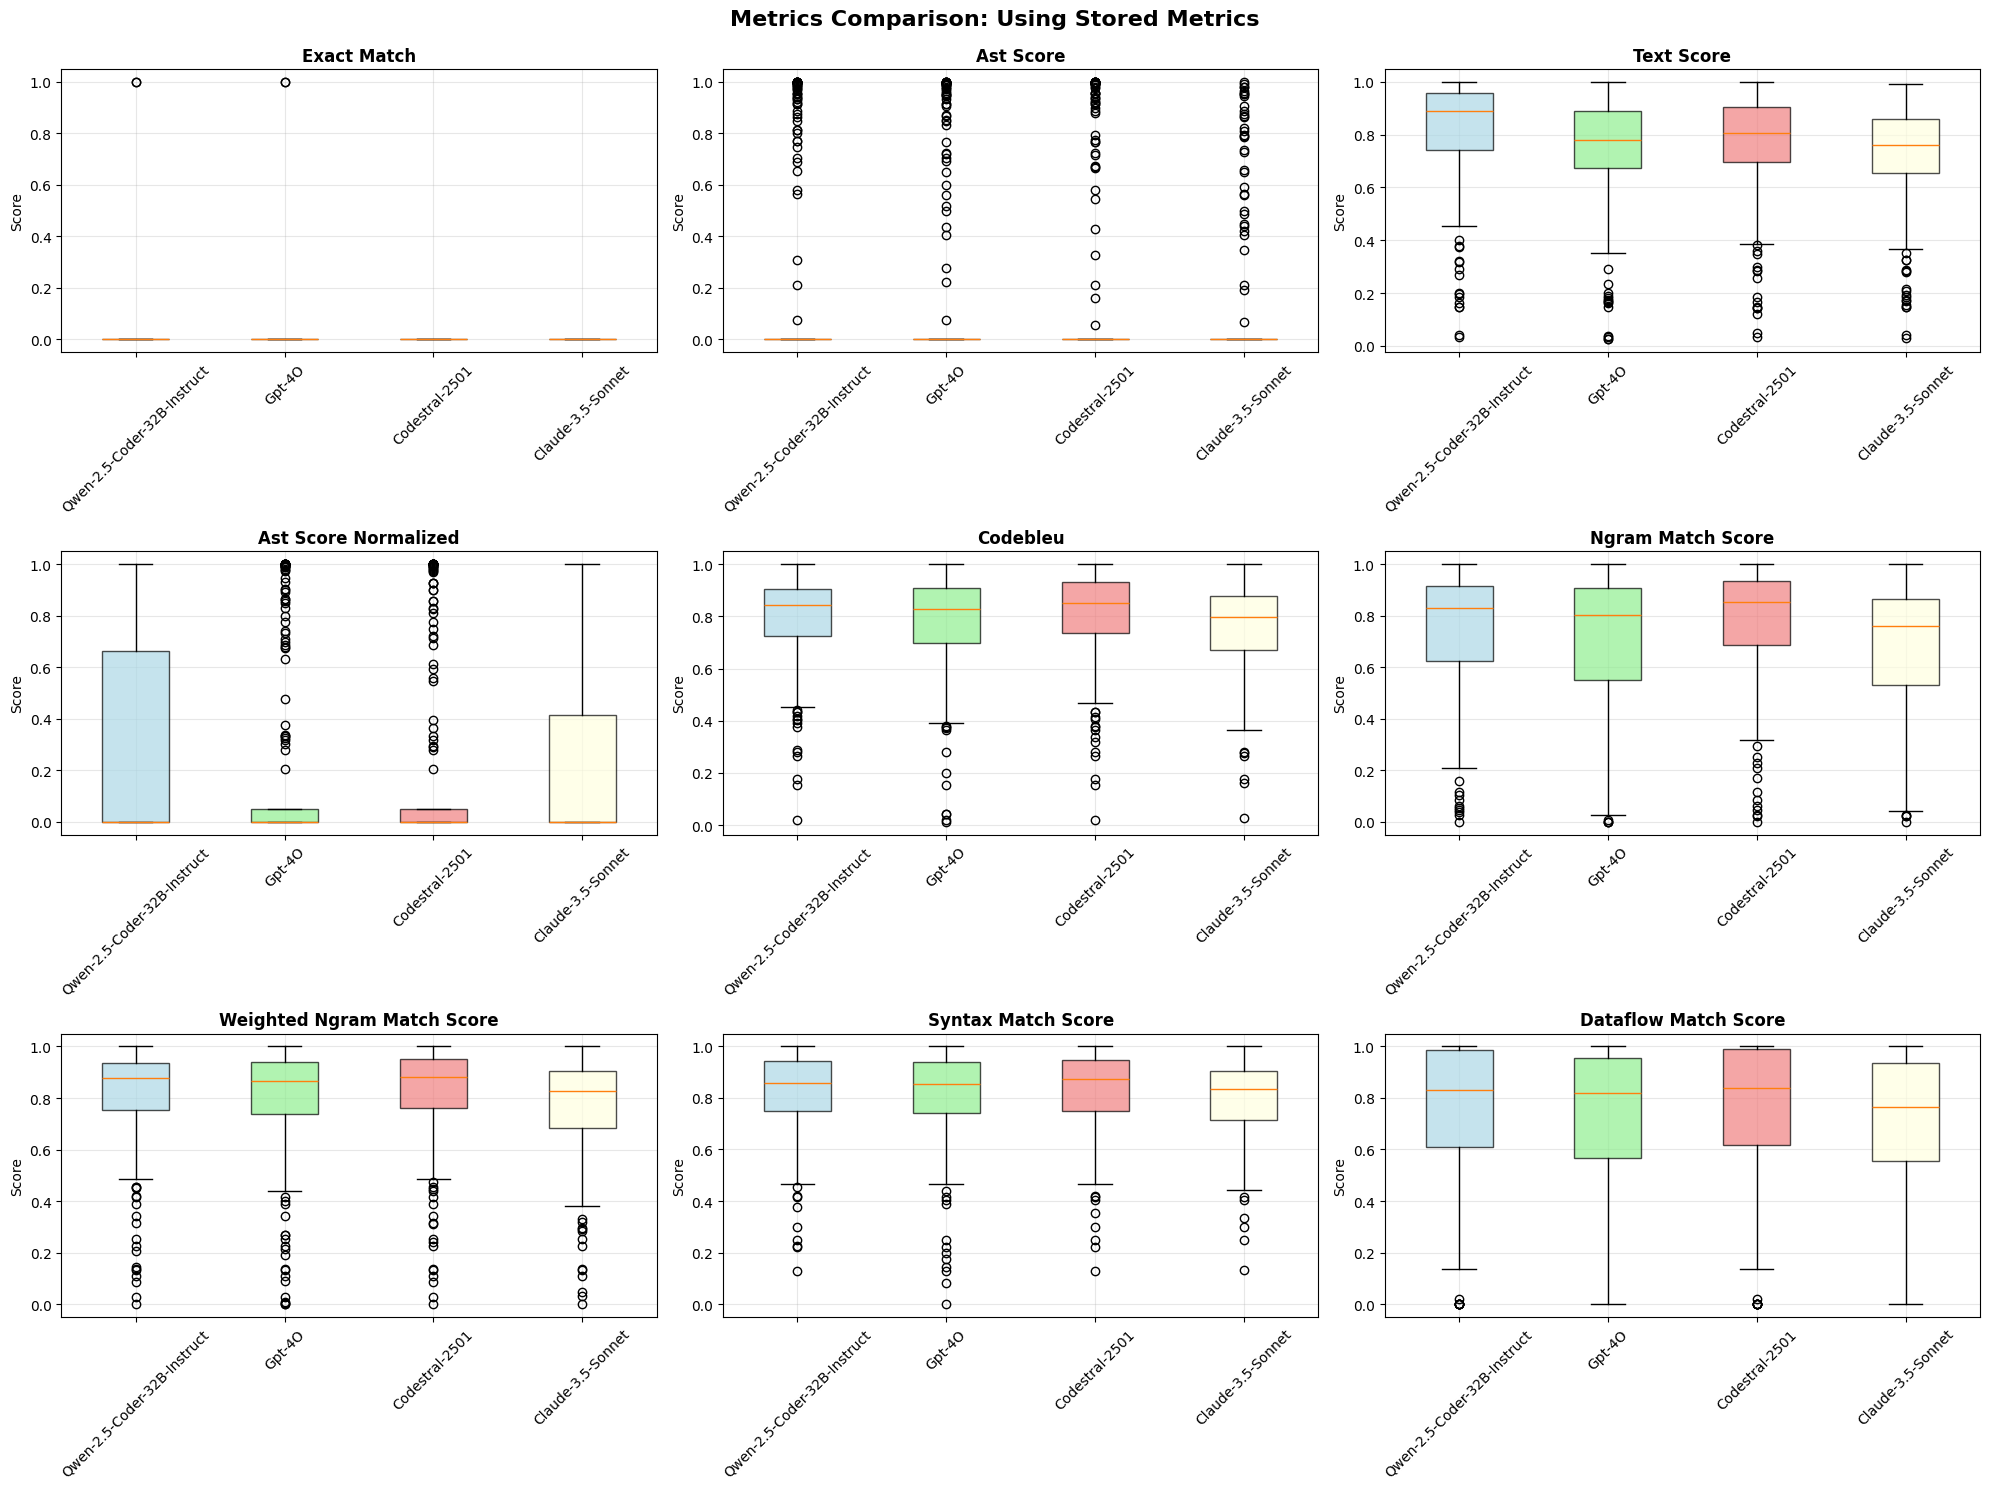


=== SUMMARY STATISTICS (FROM STORED METRICS) ===
Number of response columns: 4
Number of metrics: 9
Available metrics: ['exact_match', 'ast_score', 'text_score', 'ast_score_normalized', 'codebleu', 'ngram_match_score', 'weighted_ngram_match_score', 'syntax_match_score', 'dataflow_match_score']

Exact Match:
  Qwen-2.5-Coder-32B-Instruct: mean=0.010, std=0.100, median=0.000 (n=200)
  Gpt-4O: mean=0.010, std=0.100, median=0.000 (n=200)
  Codestral-2501: mean=0.000, std=0.000, median=0.000 (n=200)
  Claude-3.5-Sonnet: mean=0.000, std=0.000, median=0.000 (n=200)

Ast Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.211, std=0.385, median=0.000 (n=200)
  Gpt-4O: mean=0.202, std=0.373, median=0.000 (n=200)
  Codestral-2501: mean=0.204, std=0.377, median=0.000 (n=200)
  Claude-3.5-Sonnet: mean=0.126, std=0.290, median=0.000 (n=200)

Text Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.816, std=0.210, median=0.891 (n=200)
  Gpt-4O: mean=0.734, std=0.222, median=0.779 (n=200)
  Codestral-2501: mean=0

In [22]:

plot_metrics_boxplots(
    prompt_data, reference_column="after_merge_without_docstrings")

Creating boxplots using stored metrics for 4 response columns...


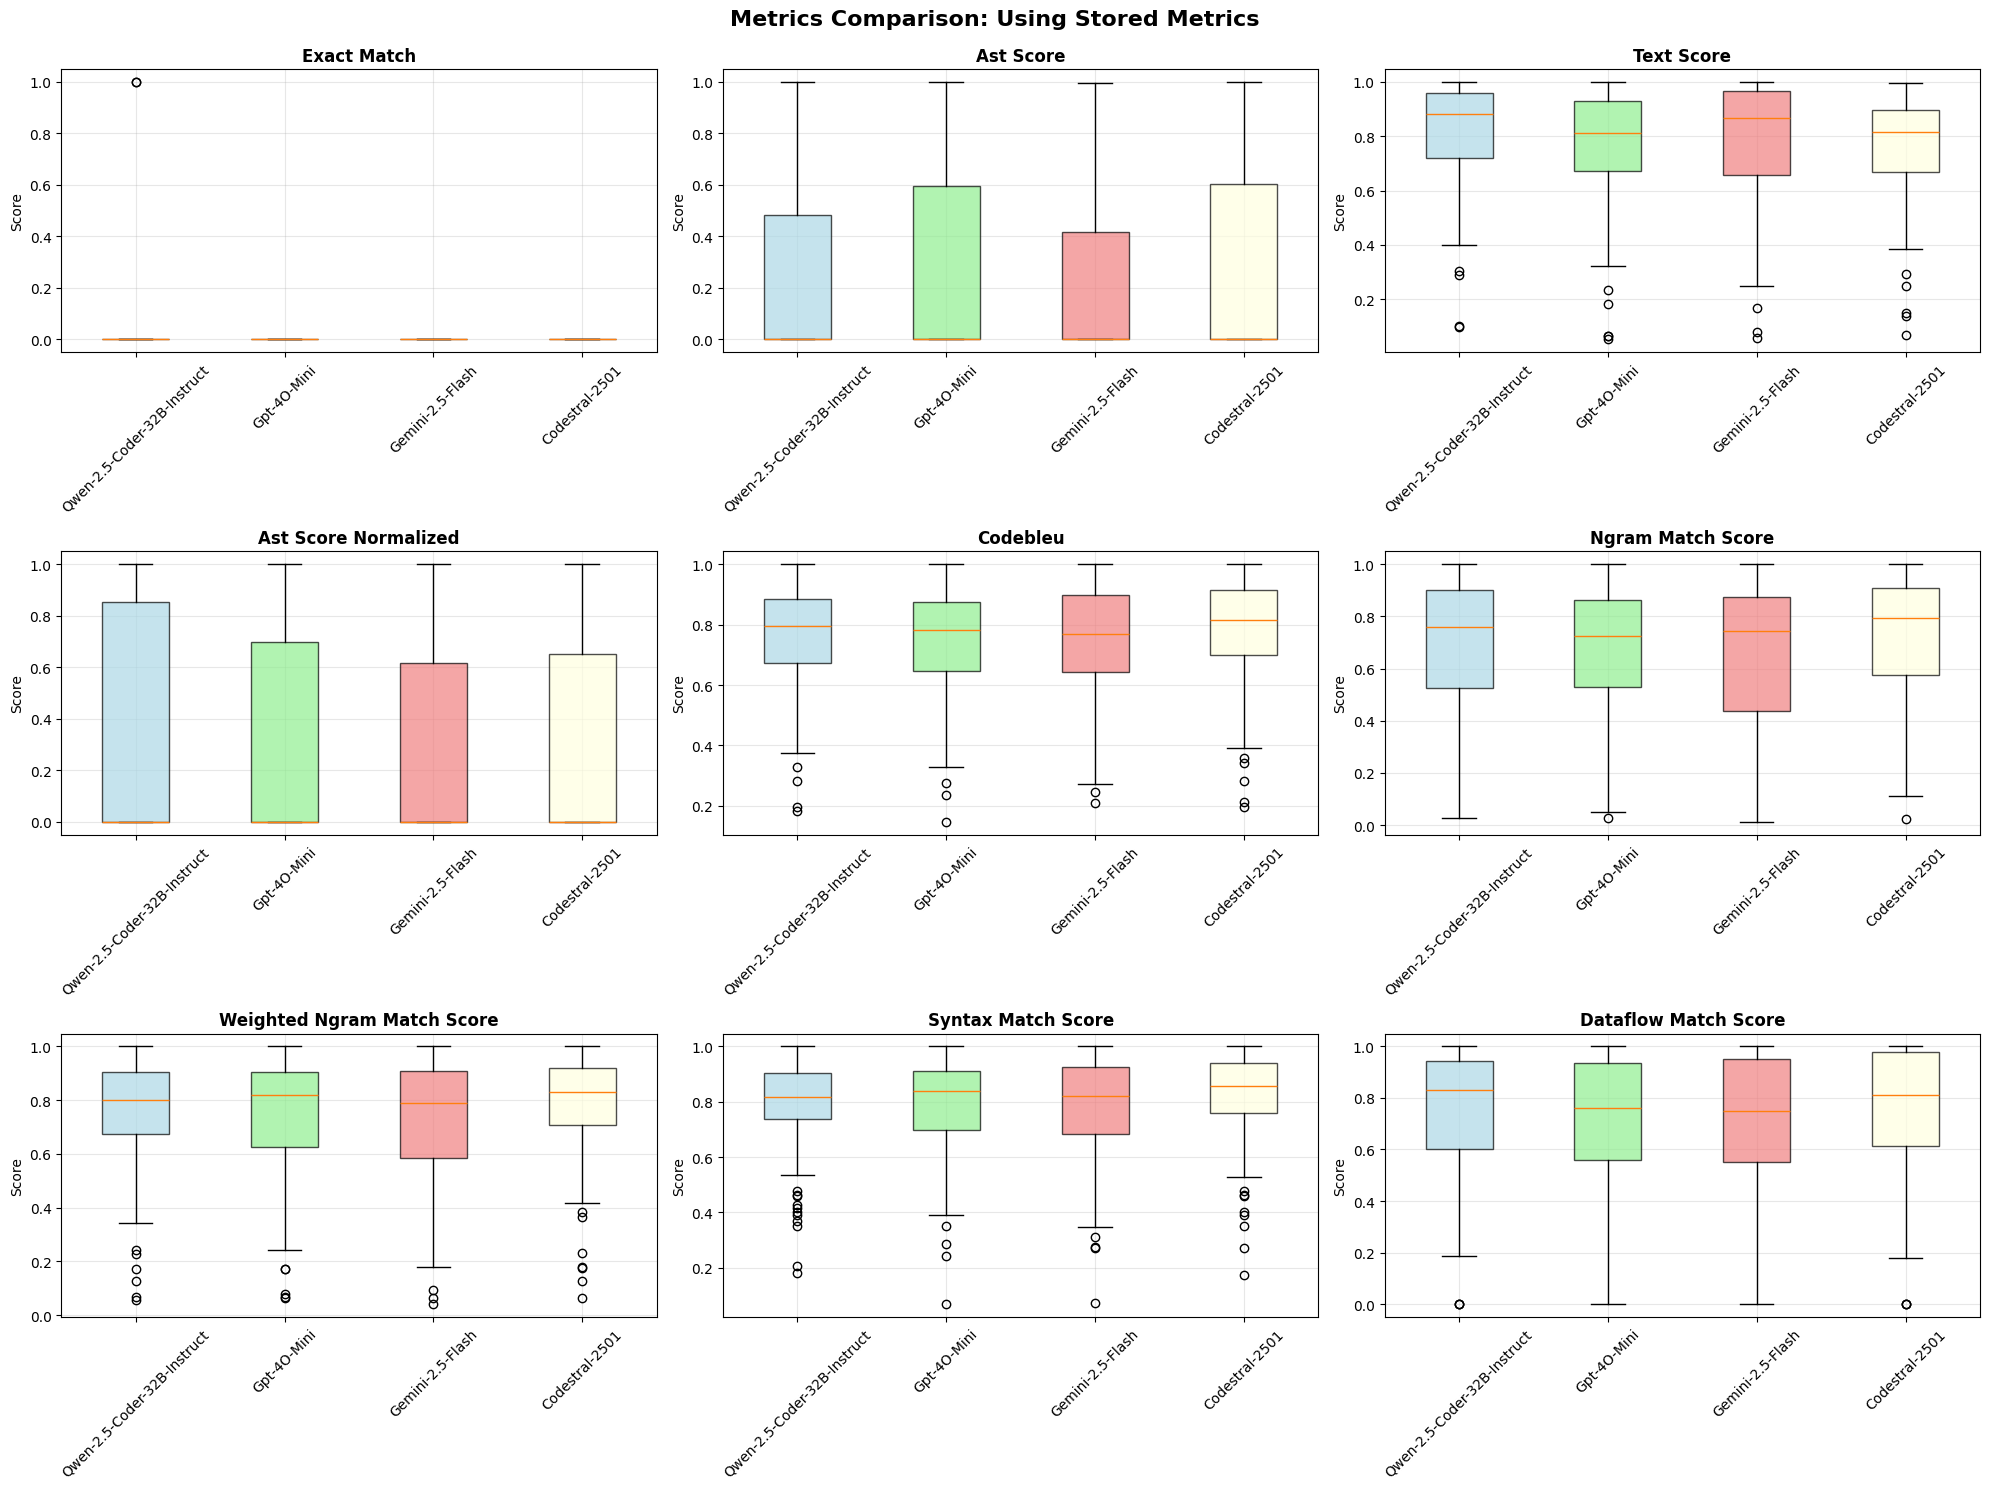


=== SUMMARY STATISTICS (FROM STORED METRICS) ===
Number of response columns: 4
Number of metrics: 9
Available metrics: ['exact_match', 'ast_score', 'text_score', 'ast_score_normalized', 'codebleu', 'ngram_match_score', 'weighted_ngram_match_score', 'syntax_match_score', 'dataflow_match_score']

Exact Match:
  Qwen-2.5-Coder-32B-Instruct: mean=0.020, std=0.141, median=0.000 (n=100)
  Gpt-4O-Mini: mean=0.000, std=0.000, median=0.000 (n=100)
  Gemini-2.5-Flash: mean=0.000, std=0.000, median=0.000 (n=100)
  Codestral-2501: mean=0.000, std=0.000, median=0.000 (n=100)

Ast Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.229, std=0.377, median=0.000 (n=100)
  Gpt-4O-Mini: mean=0.232, std=0.364, median=0.000 (n=100)
  Gemini-2.5-Flash: mean=0.213, std=0.358, median=0.000 (n=100)
  Codestral-2501: mean=0.239, std=0.380, median=0.000 (n=100)

Text Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.812, std=0.196, median=0.883 (n=100)
  Gpt-4O-Mini: mean=0.757, std=0.217, median=0.811 (n=100)
  Gemini-2.

In [13]:

plot_metrics_boxplots(
    prompt_data, reference_column="after_merge_without_docstrings")

Creating boxplots using stored metrics for 6 response columns...


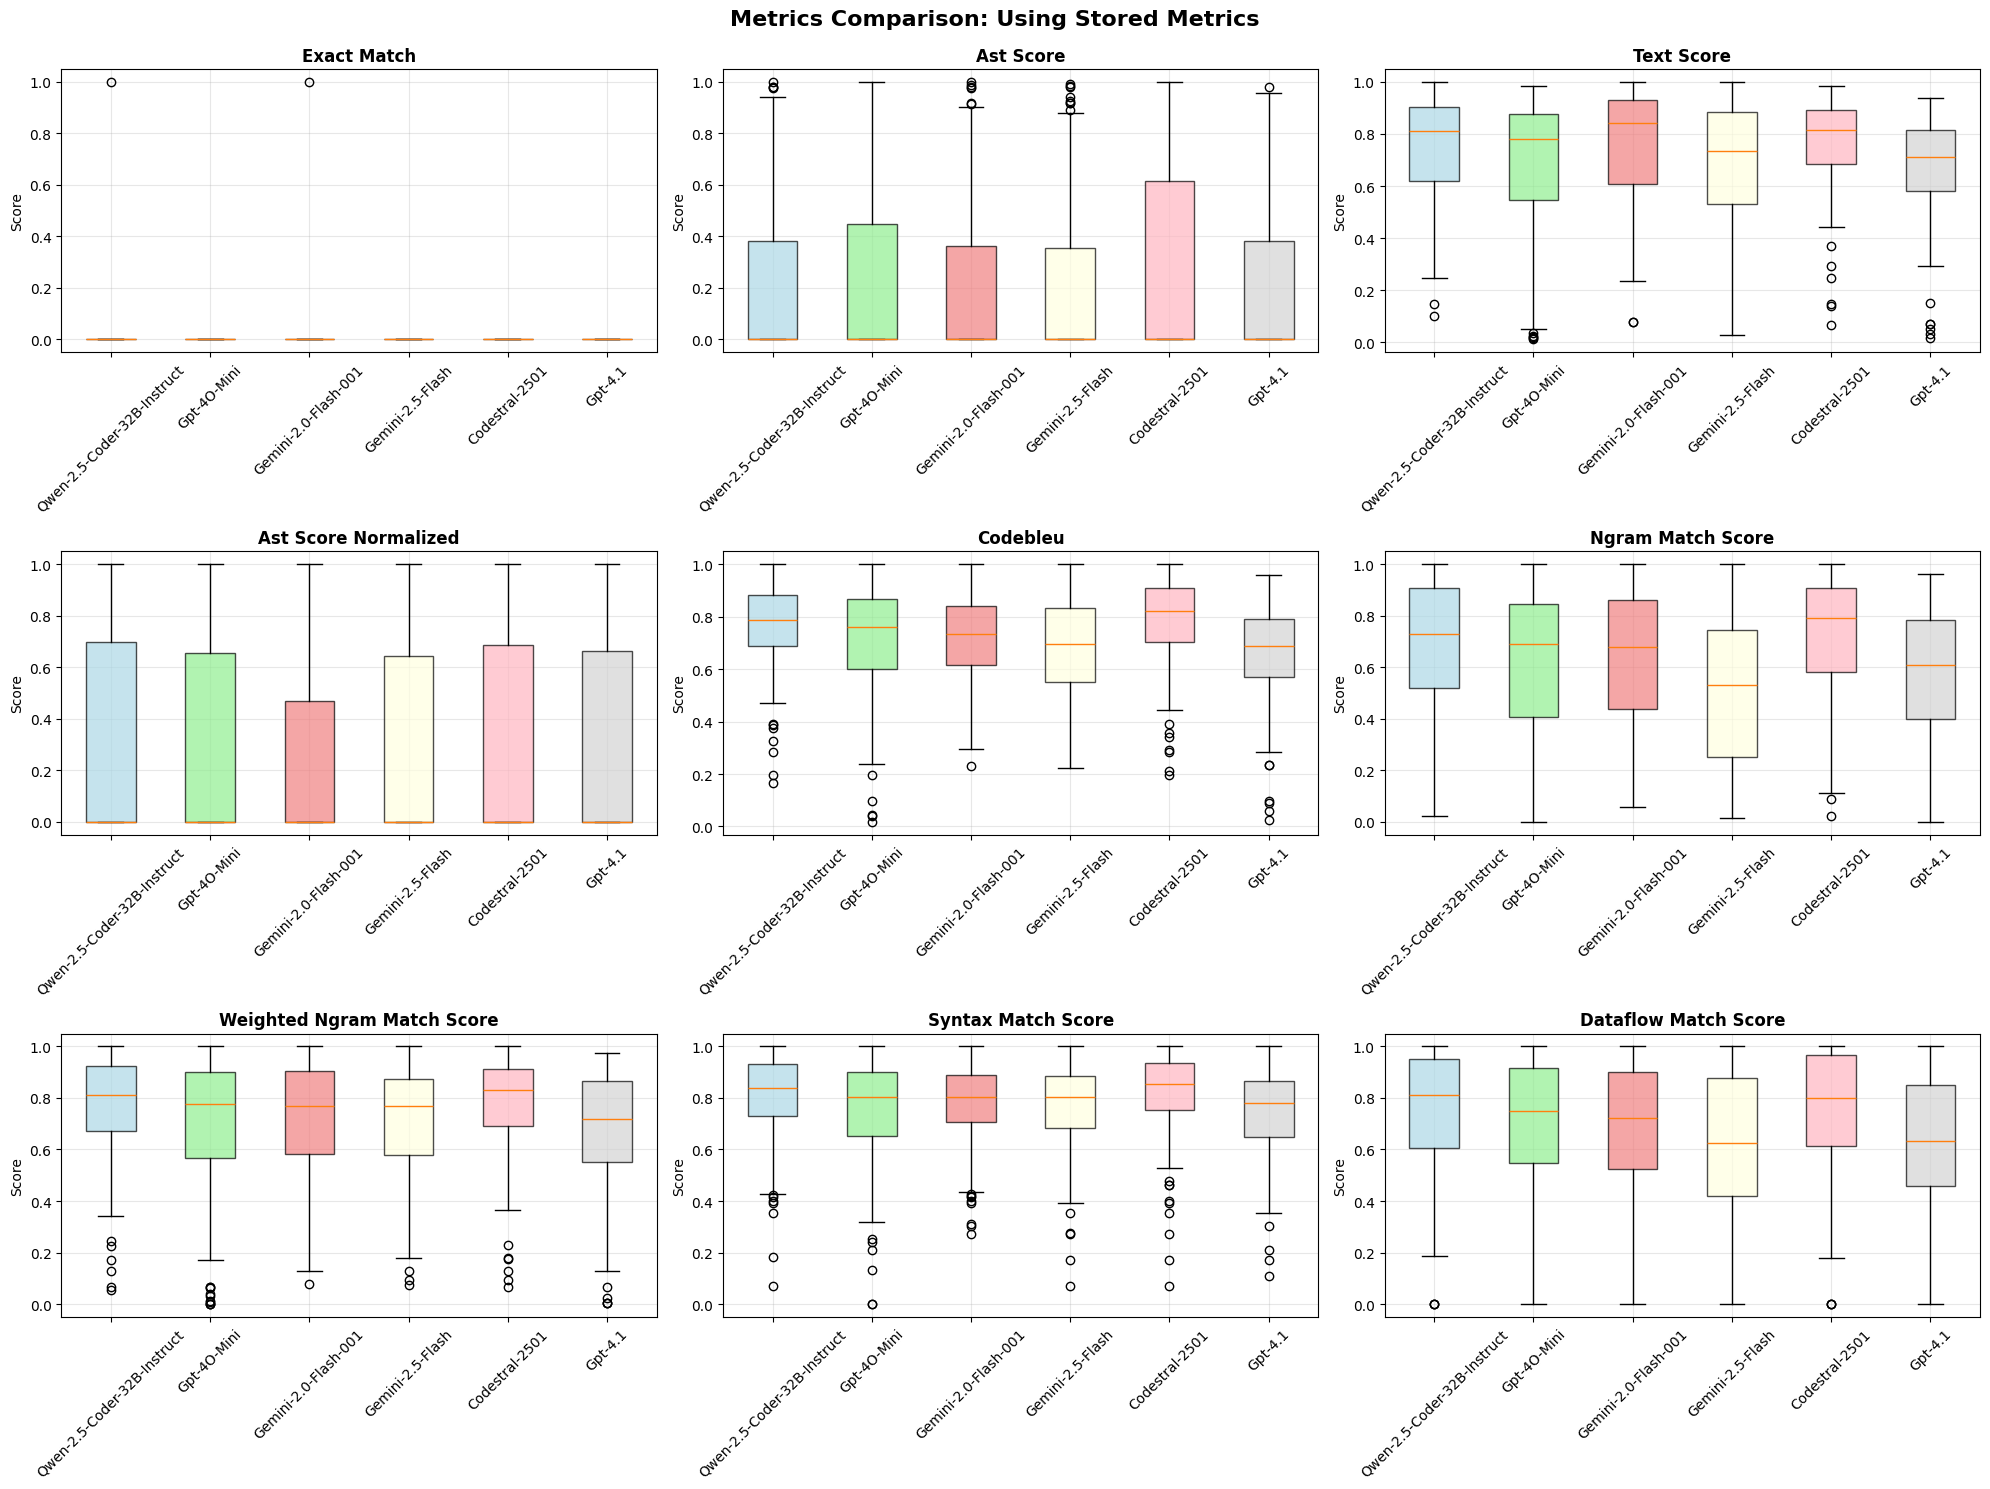


=== SUMMARY STATISTICS (FROM STORED METRICS) ===
Number of response columns: 6
Number of metrics: 9
Available metrics: ['exact_match', 'ast_score', 'text_score', 'ast_score_normalized', 'codebleu', 'ngram_match_score', 'weighted_ngram_match_score', 'syntax_match_score', 'dataflow_match_score']

Exact Match:
  Qwen-2.5-Coder-32B-Instruct: mean=0.010, std=0.100, median=0.000 (n=100)
  Gpt-4O-Mini: mean=0.000, std=0.000, median=0.000 (n=100)
  Gemini-2.0-Flash-001: mean=0.010, std=0.100, median=0.000 (n=100)
  Gemini-2.5-Flash: mean=0.000, std=0.000, median=0.000 (n=100)
  Codestral-2501: mean=0.000, std=0.000, median=0.000 (n=100)
  Gpt-4.1: mean=0.000, std=0.000, median=0.000 (n=100)

Ast Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.215, std=0.364, median=0.000 (n=100)
  Gpt-4O-Mini: mean=0.221, std=0.363, median=0.000 (n=100)
  Gemini-2.0-Flash-001: mean=0.180, std=0.319, median=0.000 (n=100)
  Gemini-2.5-Flash: mean=0.189, std=0.334, median=0.000 (n=100)
  Codestral-2501: mean=0.246,

In [ ]:
plot_metrics_boxplots(
    sample_data, reference_column="after_merge_without_docstrings")

### Syntax Match Score:
prompt = ""You are a helpful assistant that corrects the code based on the traceback error. You must respect the original code structure and the original code style""

No prompt = ""You are a helpful assistant that corrects the code based on the traceback error.""


#### Prompt 
- Qwen-2.5-Coder-32B-Instruct: mean=0.783, std=0.182, median=0.816 (n=100)
- Gpt-4O-Mini: mean=0.784, std=0.186, median=0.840 (n=100)
- Gemini-2.5-Flash: mean=0.775, std=0.193, median=0.821 (n=100)
- Codestral-2501: mean=0.814, std=0.176, median=0.856 (n=100)
#### No prompt
- Qwen-2.5-Coder-32B-Instruct: mean=0.796, std=0.188, median=0.838 (n=100)
- Gpt-4O-Mini: mean=0.741, std=0.229, median=0.804 (n=100)
- Gemini-2.0-Flash-001: mean=0.766, std=0.172, median=0.804 (n=100)
- Gemini-2.5-Flash: mean=0.757, std=0.191, median=0.805 (n=100)
- Codestral-2501: mean=0.804, std=0.190, median=0.854 (n=100)
- Gpt-4.1: mean=0.735, std=0.184, median=0.781 (n=100)

### CodeBleu
#### Prompt
- Qwen-2.5-Coder-32B-Instruct: mean=0.757, std=0.181, median=0.797 (n=100)
- Gpt-4O-Mini: mean=0.744, std=0.181, median=0.782 (n=100)
- Gemini-2.5-Flash: mean=0.728, std=0.198, median=0.768 (n=100)
- Codestral-2501: mean=0.776, std=0.184, median=0.817 (n=100)
#### No prompt
- Qwen-2.5-Coder-32B-Instruct: mean=0.756, std=0.181, median=0.786 (n=100)
- Gpt-4O-Mini: mean=0.703, std=0.225, median=0.761 (n=100)
- Gemini-2.0-Flash-001: mean=0.716, std=0.172, median=0.732 (n=100)
- Gemini-2.5-Flash: mean=0.678, std=0.187, median=0.698 (n=100)
- Codestral-2501: mean=0.771, std=0.187, median=0.822 (n=100)
- Gpt-4.1: mean=0.661, std=0.196, median=0.688 (n=100)

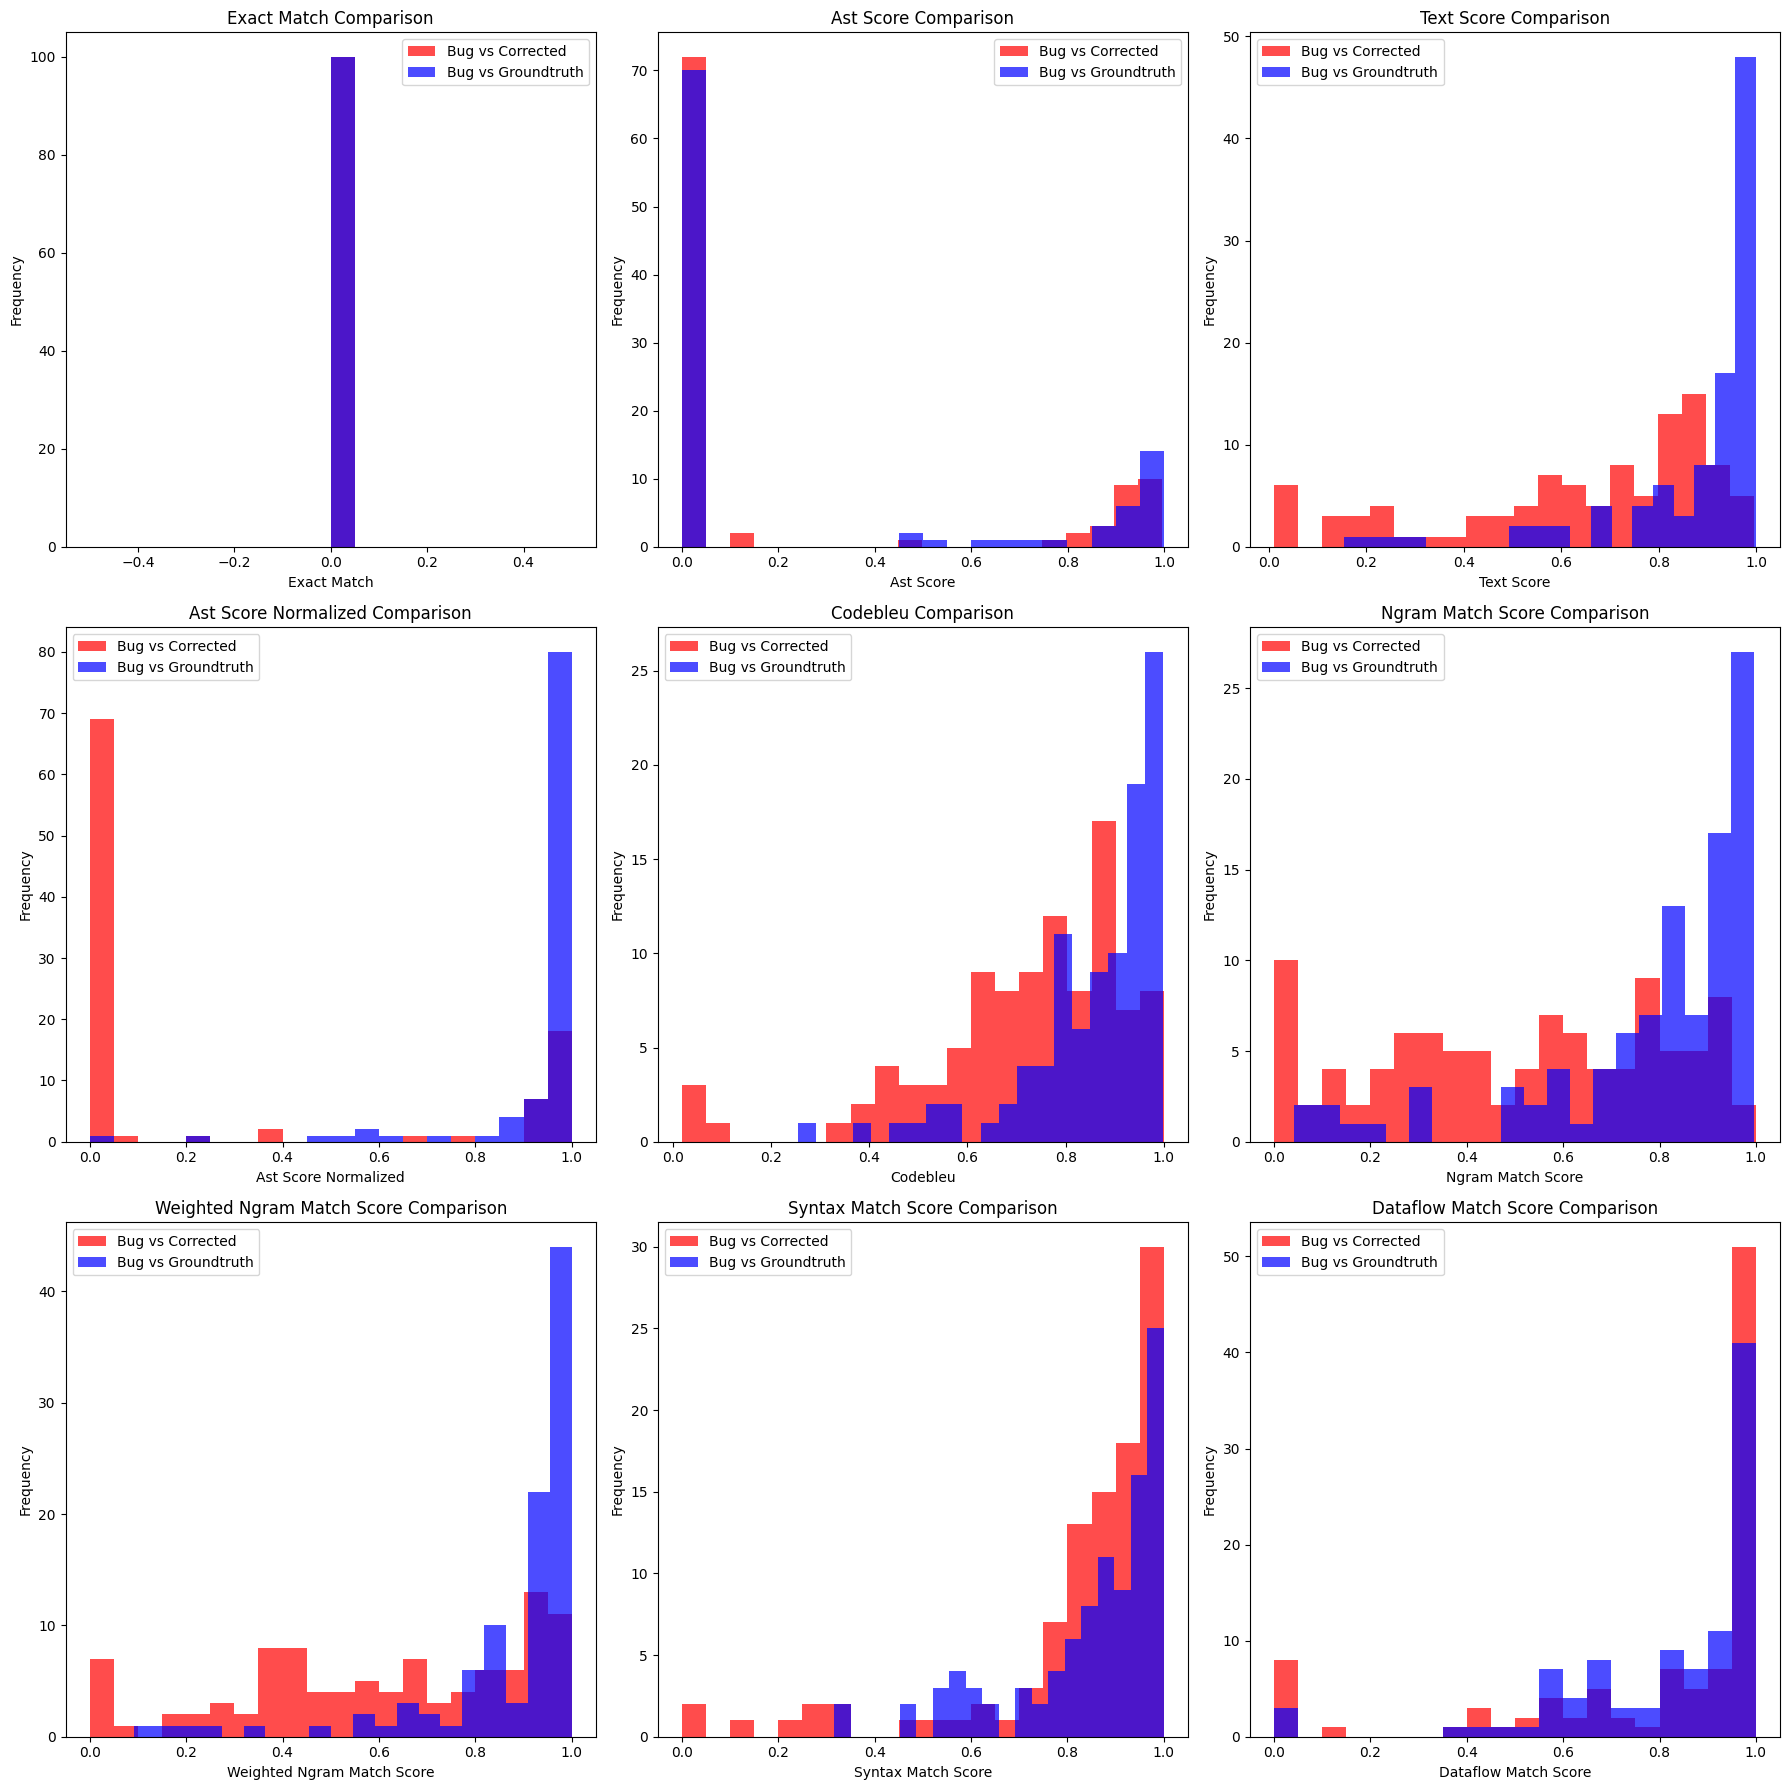

=== ALL METRICS STATISTICS ===
Exact Match - Bug vs Corrected: mean=0.000, std=0.000
Exact Match - Bug vs Groundtruth: mean=0.000, std=0.000
Ast Score - Bug vs Corrected: mean=0.239, std=0.401
Ast Score - Bug vs Groundtruth: mean=0.262, std=0.410
Text Score - Bug vs Corrected: mean=0.640, std=0.274
Text Score - Bug vs Groundtruth: mean=0.879, std=0.176
Ast Score Normalized - Bug vs Corrected: mean=0.269, std=0.423
Ast Score Normalized - Bug vs Groundtruth: mean=0.945, std=0.157
Codebleu - Bug vs Corrected: mean=0.719, std=0.208
Codebleu - Bug vs Groundtruth: mean=0.855, std=0.145
Ngram Match Score - Bug vs Corrected: mean=0.509, std=0.294
Ngram Match Score - Bug vs Groundtruth: mean=0.789, std=0.232
Weighted Ngram Match Score - Bug vs Corrected: mean=0.613, std=0.291
Weighted Ngram Match Score - Bug vs Groundtruth: mean=0.870, std=0.188
Syntax Match Score - Bug vs Corrected: mean=0.827, std=0.219
Syntax Match Score - Bug vs Groundtruth: mean=0.847, std=0.160
Dataflow Match Score - Bug 

In [ ]:
compare_metrics_versus_bug_histograms(
    sample_data['before_merge'], sample_data['after_merge'], p['response_gpt-4o-mini'])

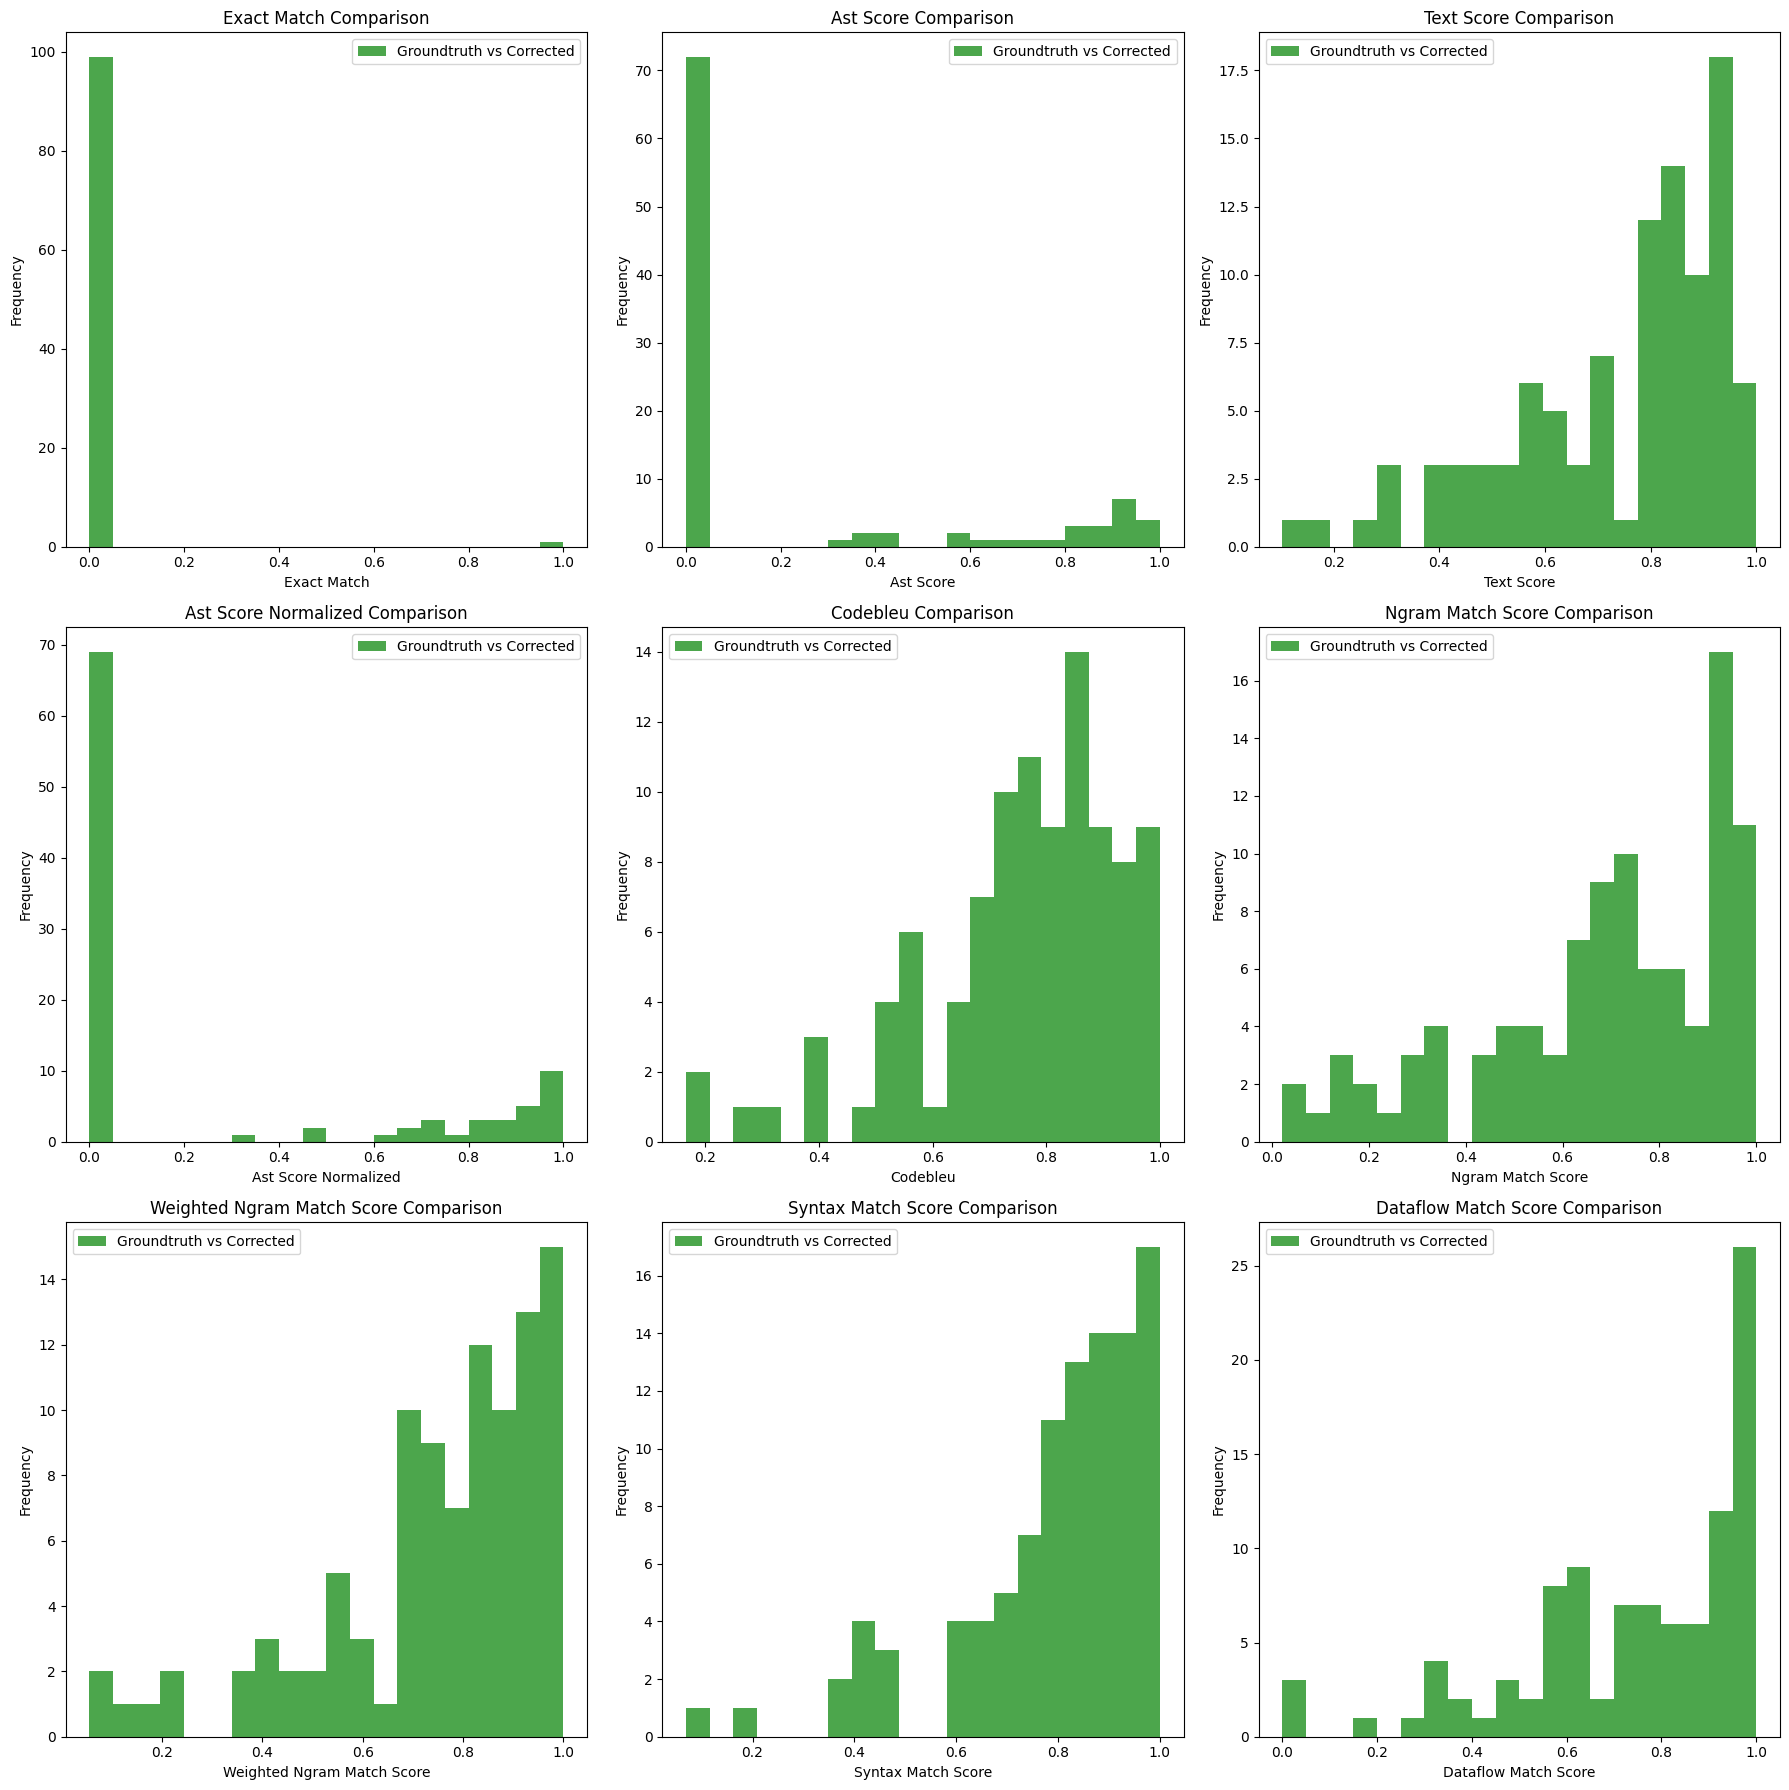

=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===
Exact Match - Groundtruth vs Corrected: mean=0.010, std=0.099
Ast Score - Groundtruth vs Corrected: mean=0.215, std=0.363
Text Score - Groundtruth vs Corrected: mean=0.743, std=0.205
Ast Score Normalized - Groundtruth vs Corrected: mean=0.259, std=0.398
Codebleu - Groundtruth vs Corrected: mean=0.757, std=0.180
Ngram Match Score - Groundtruth vs Corrected: mean=0.682, std=0.256
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.749, std=0.224
Syntax Match Score - Groundtruth vs Corrected: mean=0.796, std=0.187
Dataflow Match Score - Groundtruth vs Corrected: mean=0.744, std=0.245


In [17]:
compare_groundtruth_vs_corrected_histograms(
    sample_data['after_merge_without_docstrings'], sample_data['response_qwen-2.5-coder-32b-instruct'])

#### qwen

Exact Match - Groundtruth vs Corrected: mean=0.010, std=0.099
Ast Score - Groundtruth vs Corrected: mean=0.201, std=0.346
Text Score - Groundtruth vs Corrected: mean=0.734, std=0.208
Ast Score Normalized - Groundtruth vs Corrected: mean=0.237, std=0.382
Codebleu - Groundtruth vs Corrected: mean=0.733, std=0.197
Ngram Match Score - Groundtruth vs Corrected: mean=0.644, std=0.298
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.706, std=0.258
Syntax Match Score - Groundtruth vs Corrected: mean=0.783, std=0.189
Dataflow Match Score - Groundtruth vs Corrected: mean=0.739, std=0.257

#### gpt

Exact Match - Groundtruth vs Corrected: mean=0.000, std=0.000
Ast Score - Groundtruth vs Corrected: mean=0.200, std=0.347
Text Score - Groundtruth vs Corrected: mean=0.652, std=0.274
Ast Score Normalized - Groundtruth vs Corrected: mean=0.253, std=0.390
Codebleu - Groundtruth vs Corrected: mean=0.662, std=0.226
Ngram Match Score - Groundtruth vs Corrected: mean=0.547, std=0.322
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.623, std=0.308
Syntax Match Score - Groundtruth vs Corrected: mean=0.740, std=0.230
Dataflow Match Score - Groundtruth vs Corrected: mean=0.660, std=0.290

Boxplot pra cada modelo vs gt lado a lado
adicionar modelos de tamanho similares.

sera que se eu pedir (mudança de prompt) para ele fixar o estilo ele perde a corretude no bug

add mais 2 modelos (pequeno e medio)


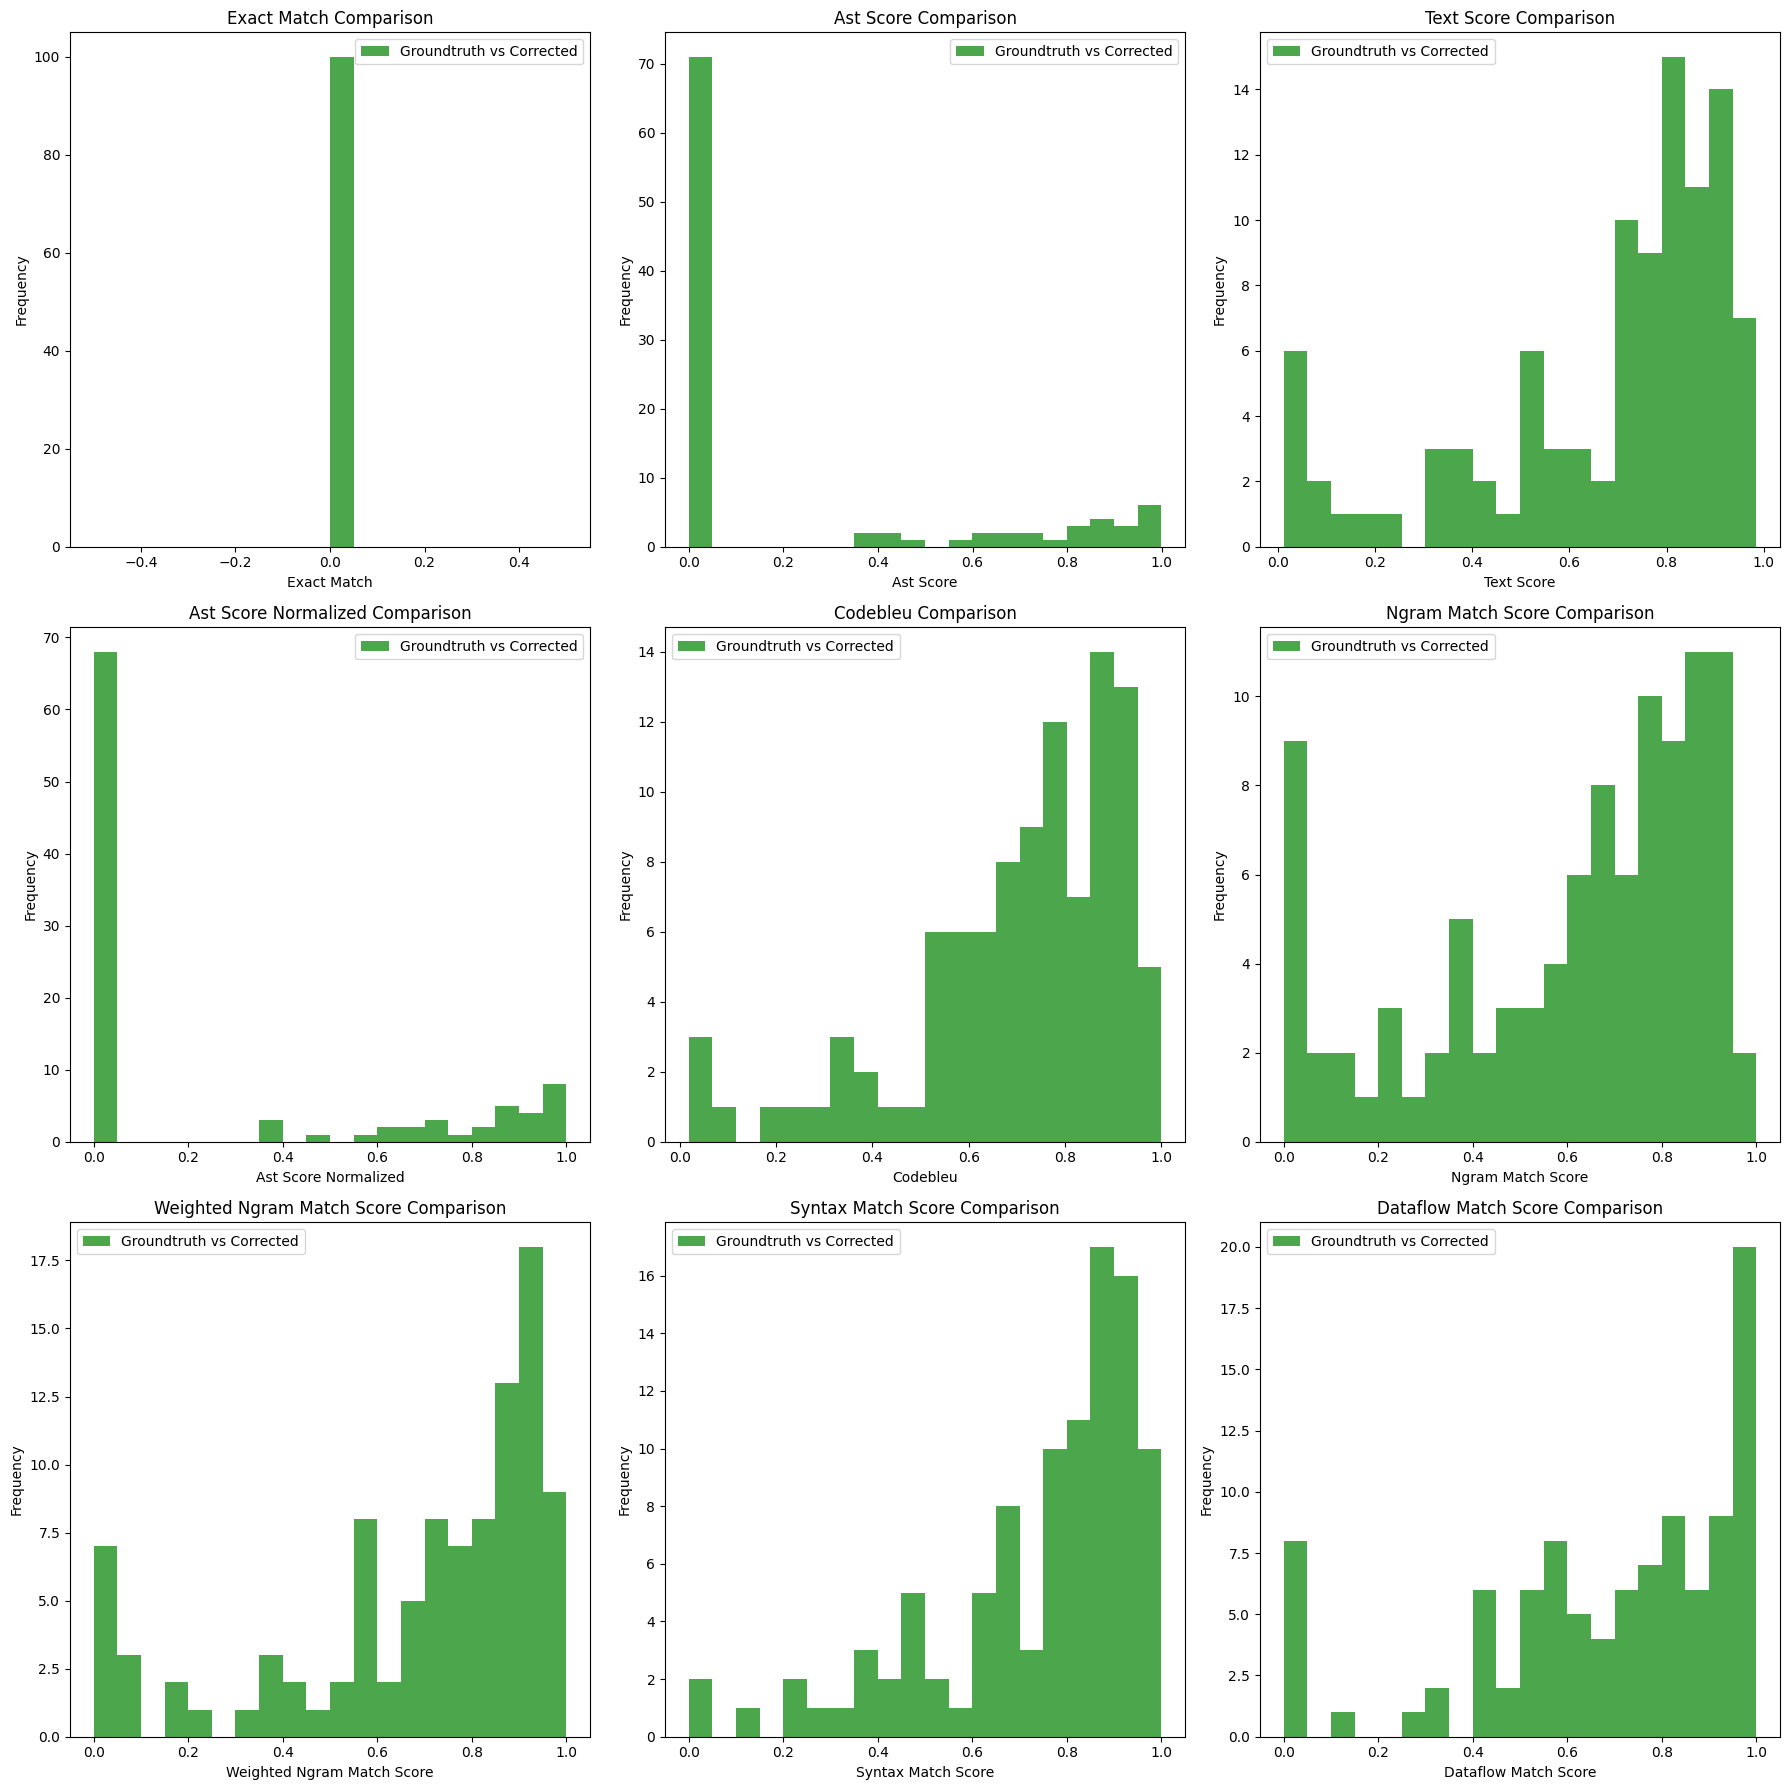

=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===
Exact Match - Groundtruth vs Corrected: mean=0.000, std=0.000
Ast Score - Groundtruth vs Corrected: mean=0.221, std=0.362
Text Score - Groundtruth vs Corrected: mean=0.678, std=0.267
Ast Score Normalized - Groundtruth vs Corrected: mean=0.254, std=0.386
Codebleu - Groundtruth vs Corrected: mean=0.704, std=0.223
Ngram Match Score - Groundtruth vs Corrected: mean=0.605, std=0.291
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.685, std=0.287
Syntax Match Score - Groundtruth vs Corrected: mean=0.741, std=0.228
Dataflow Match Score - Groundtruth vs Corrected: mean=0.688, std=0.282


In [18]:
compare_groundtruth_vs_corrected_histograms(
    sample_data['after_merge_without_docstrings'], sample_data['response_gpt-4o-mini'])

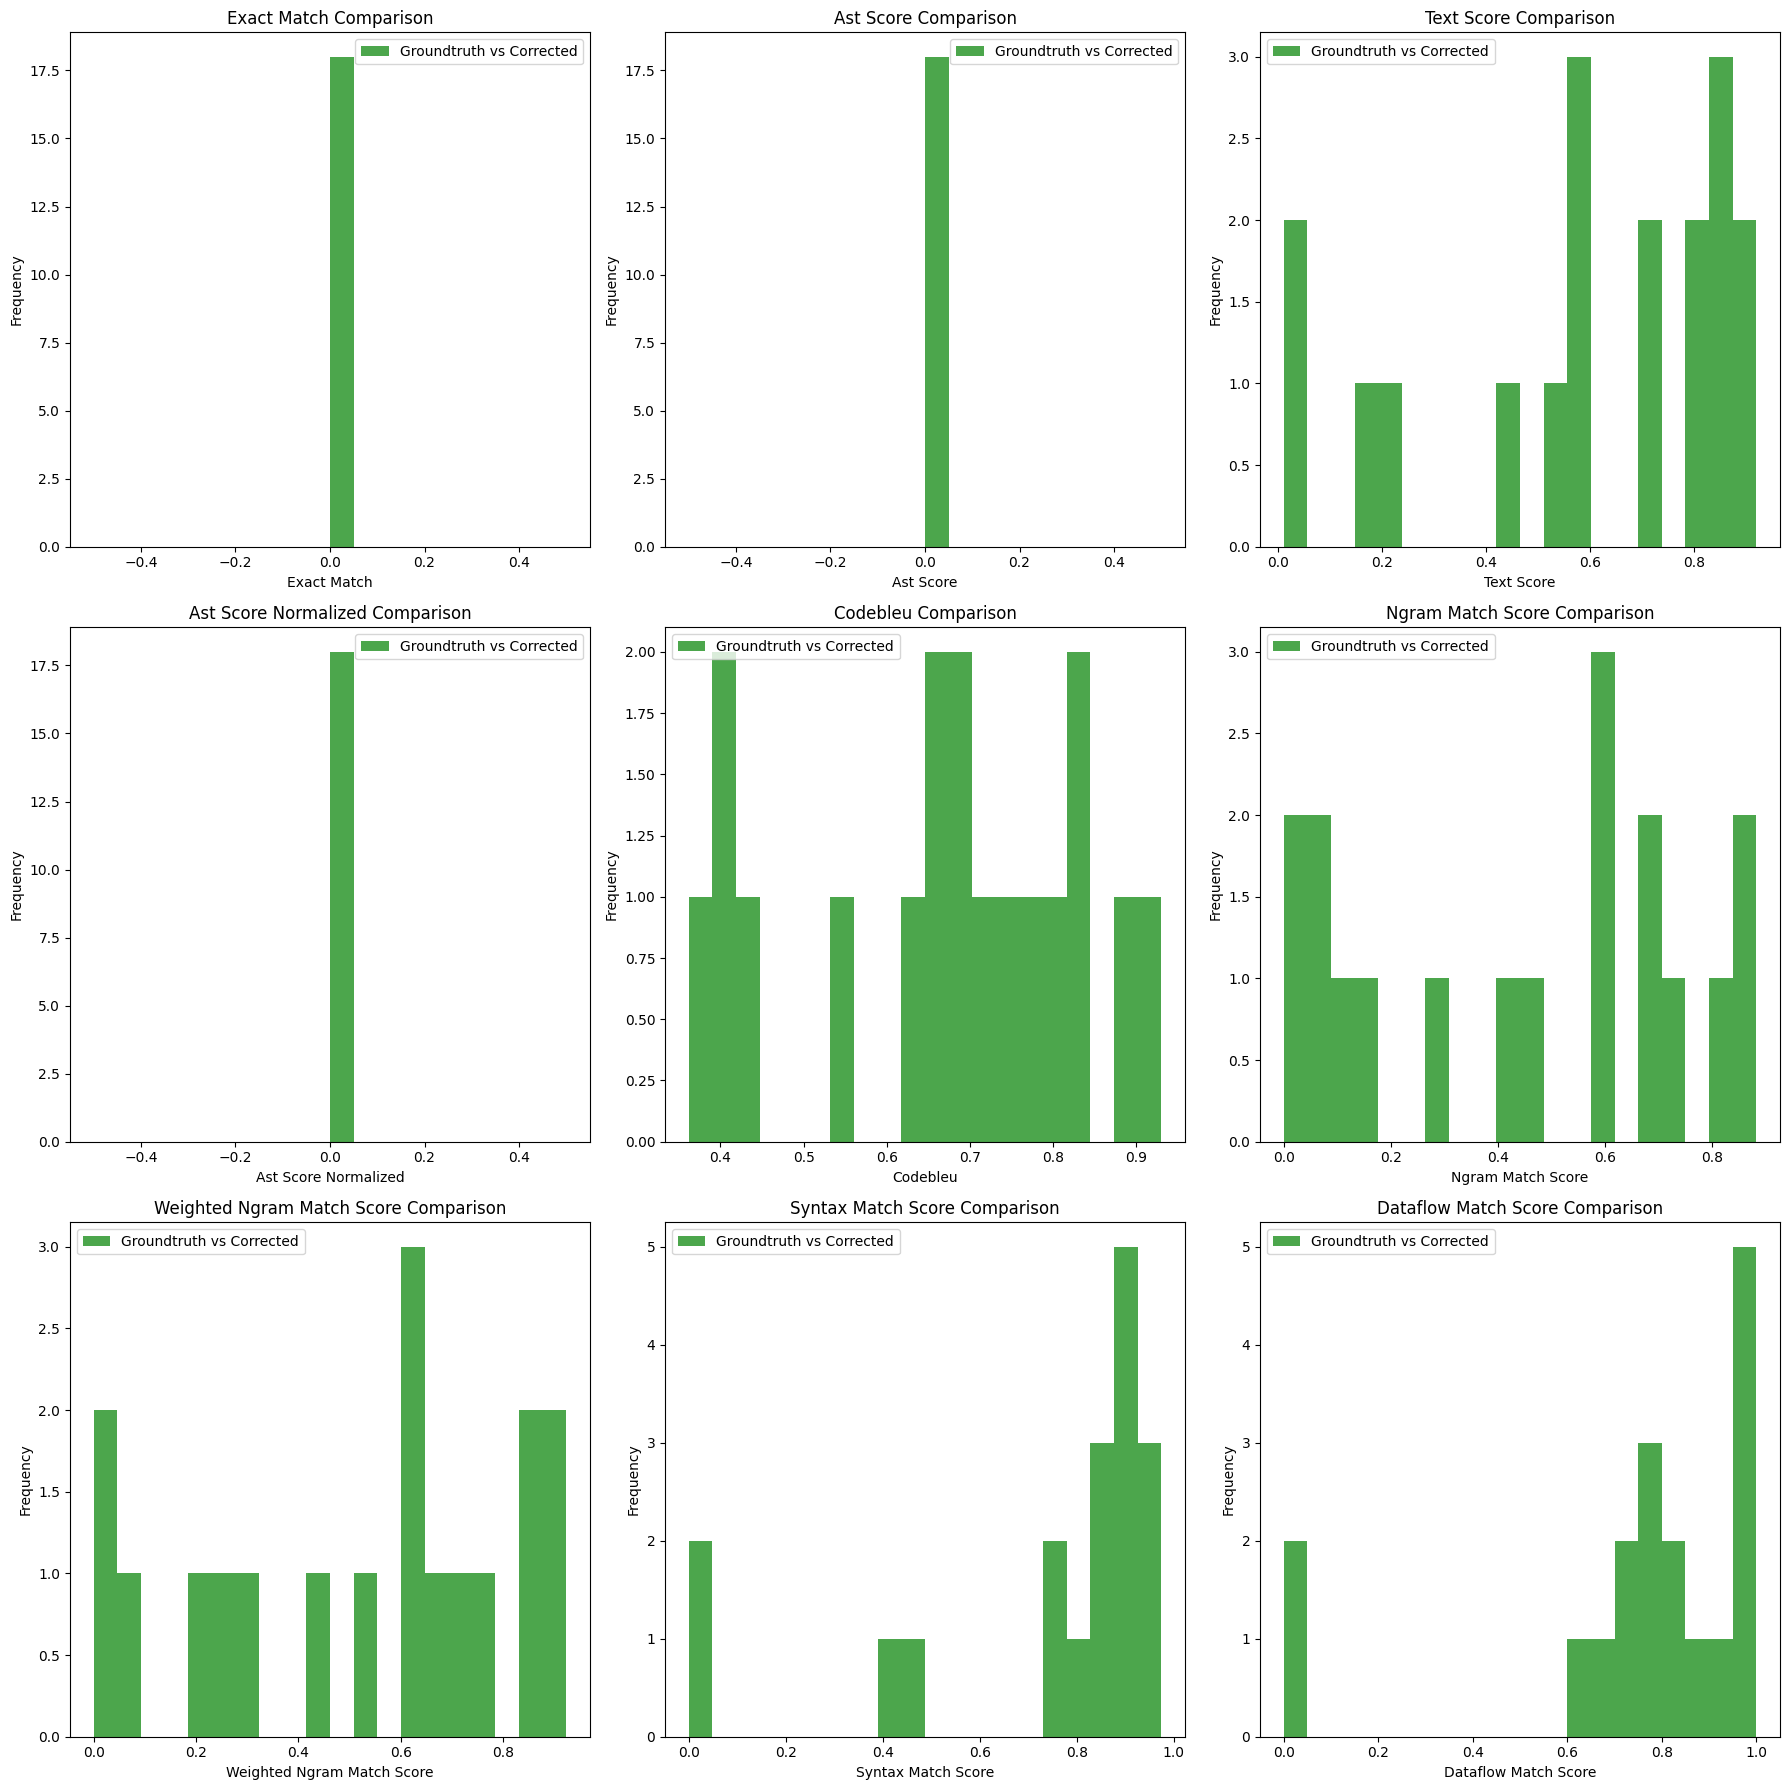

=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===
Exact Match - Groundtruth vs Corrected: mean=0.000, std=0.000
Ast Score - Groundtruth vs Corrected: mean=0.000, std=0.000
Text Score - Groundtruth vs Corrected: mean=0.587, std=0.287
Ast Score Normalized - Groundtruth vs Corrected: mean=0.000, std=0.000
Codebleu - Groundtruth vs Corrected: mean=0.667, std=0.170
Ngram Match Score - Groundtruth vs Corrected: mean=0.446, std=0.305
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.517, std=0.299
Syntax Match Score - Groundtruth vs Corrected: mean=0.725, std=0.298
Dataflow Match Score - Groundtruth vs Corrected: mean=0.748, std=0.290


In [19]:
compare_groundtruth_vs_corrected_histograms(sample_data[sample_data['traceback_type'] == 'AttributeError']
                                            ['after_merge'], sample_data[sample_data['traceback_type'] == 'AttributeError']['response_gpt-4o-mini'])

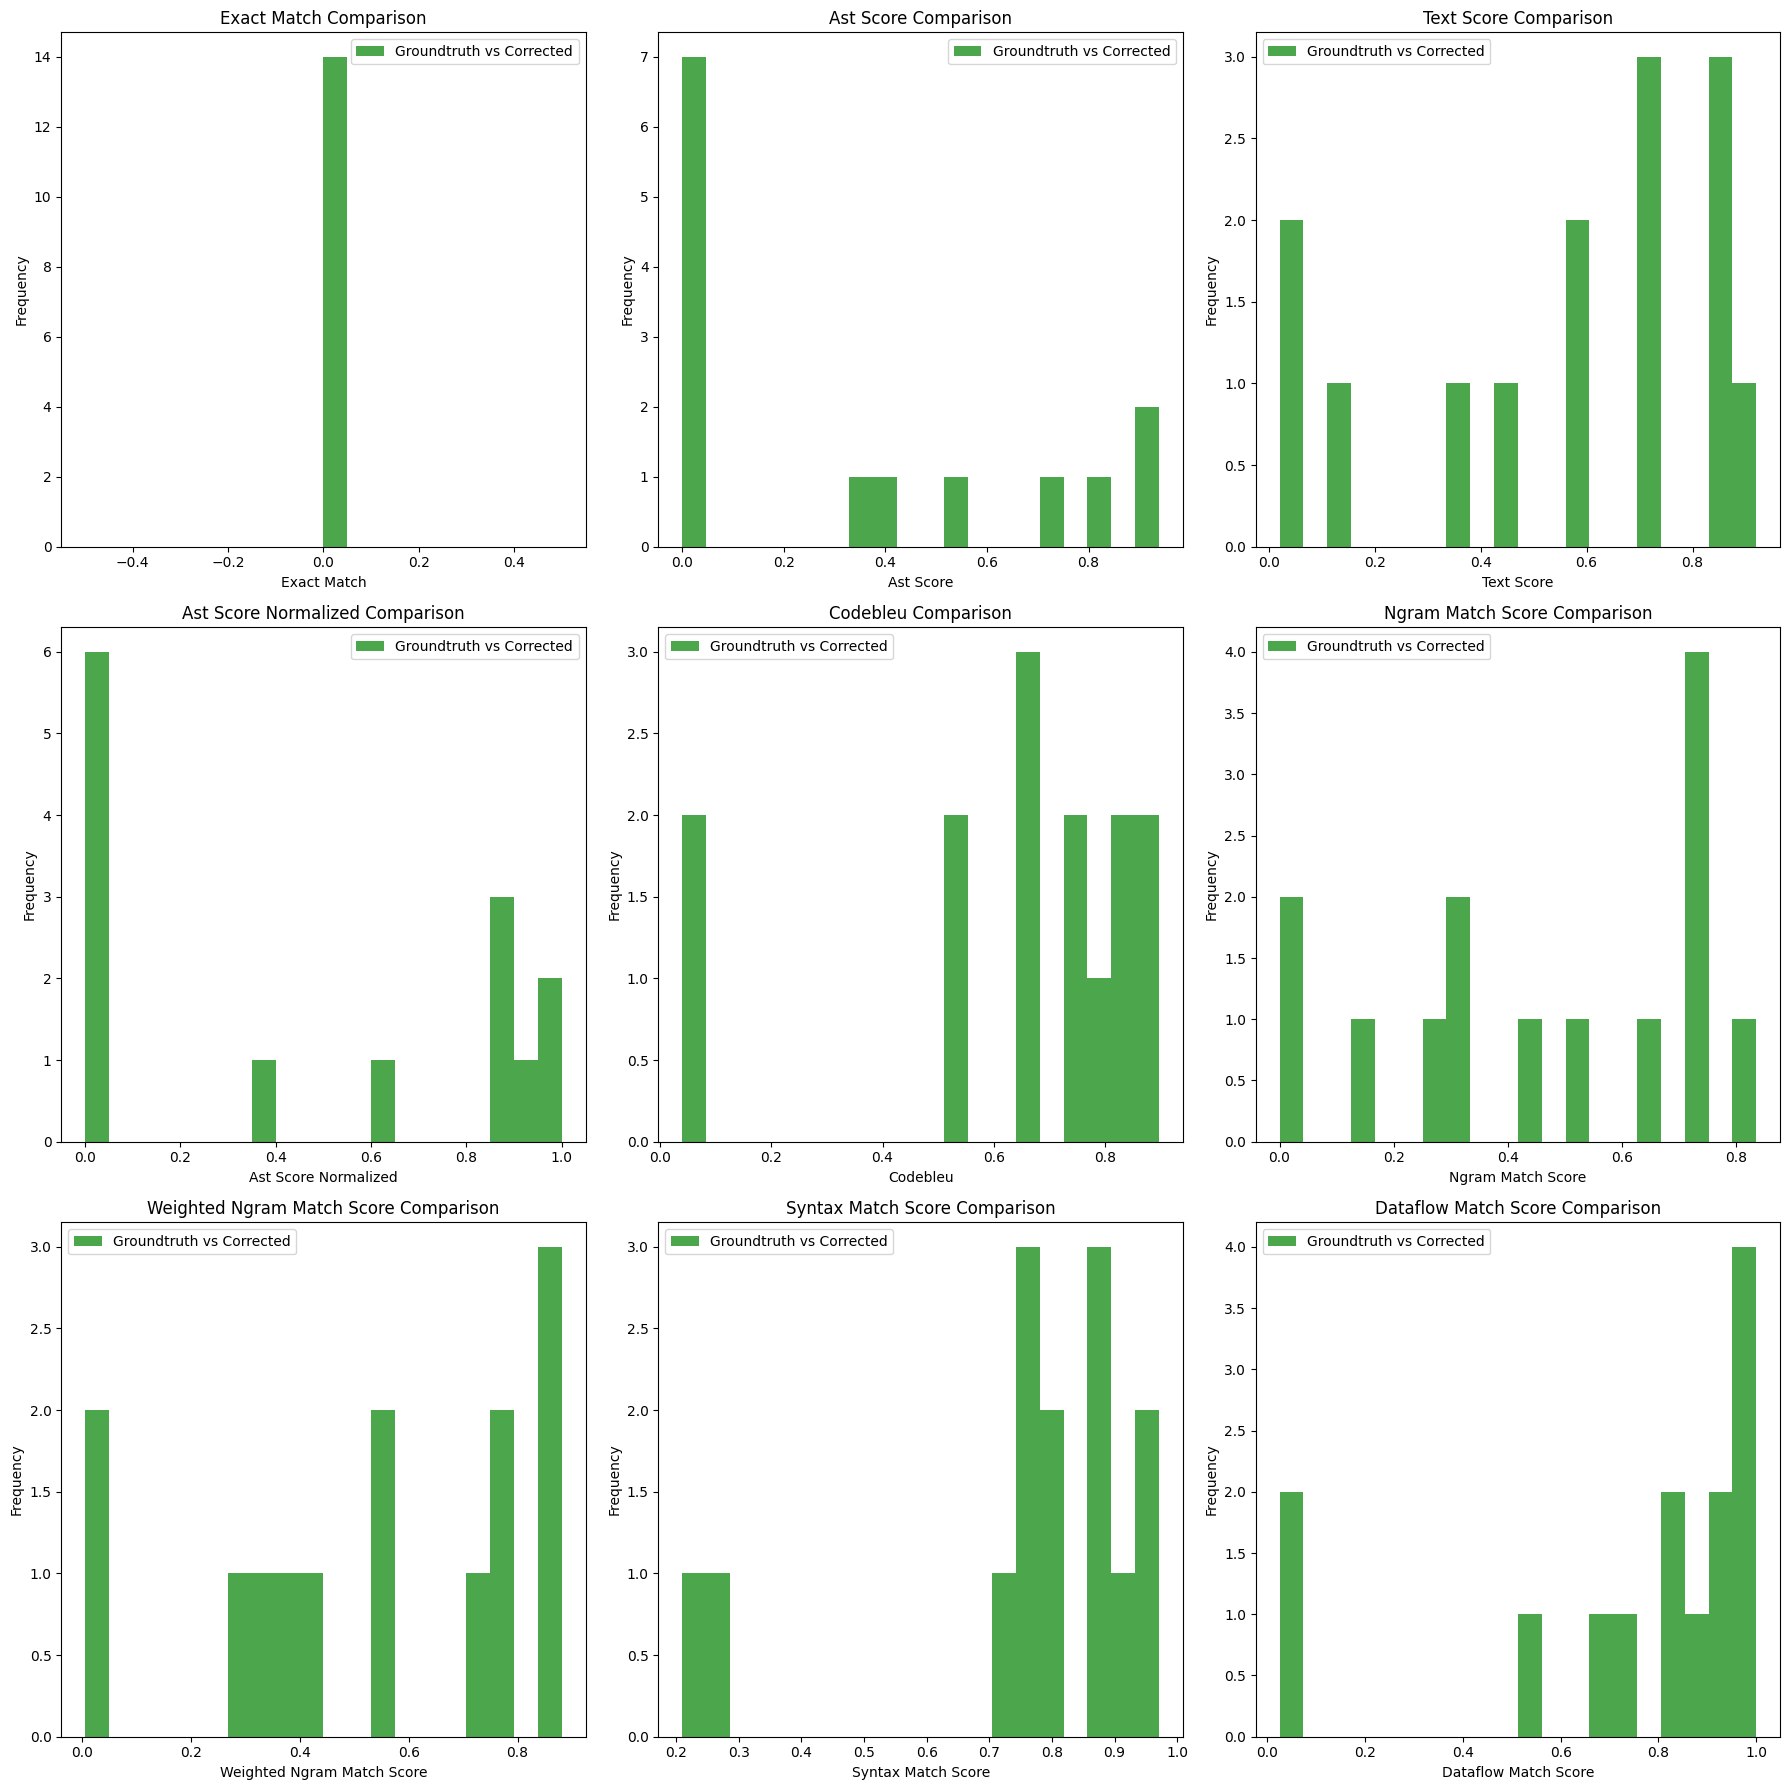

=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===
Exact Match - Groundtruth vs Corrected: mean=0.000, std=0.000
Ast Score - Groundtruth vs Corrected: mean=0.342, std=0.374
Text Score - Groundtruth vs Corrected: mean=0.563, std=0.301
Ast Score Normalized - Groundtruth vs Corrected: mean=0.468, std=0.428
Codebleu - Groundtruth vs Corrected: mean=0.630, std=0.264
Ngram Match Score - Groundtruth vs Corrected: mean=0.465, std=0.280
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.531, std=0.285
Syntax Match Score - Groundtruth vs Corrected: mean=0.751, std=0.223
Dataflow Match Score - Groundtruth vs Corrected: mean=0.740, std=0.316


In [20]:
compare_groundtruth_vs_corrected_histograms(sample_data[sample_data['traceback_type'] == 'ValueError']
                                            ['after_merge'], sample_data[sample_data['traceback_type'] == 'ValueError']['response_gpt-4o-mini'])

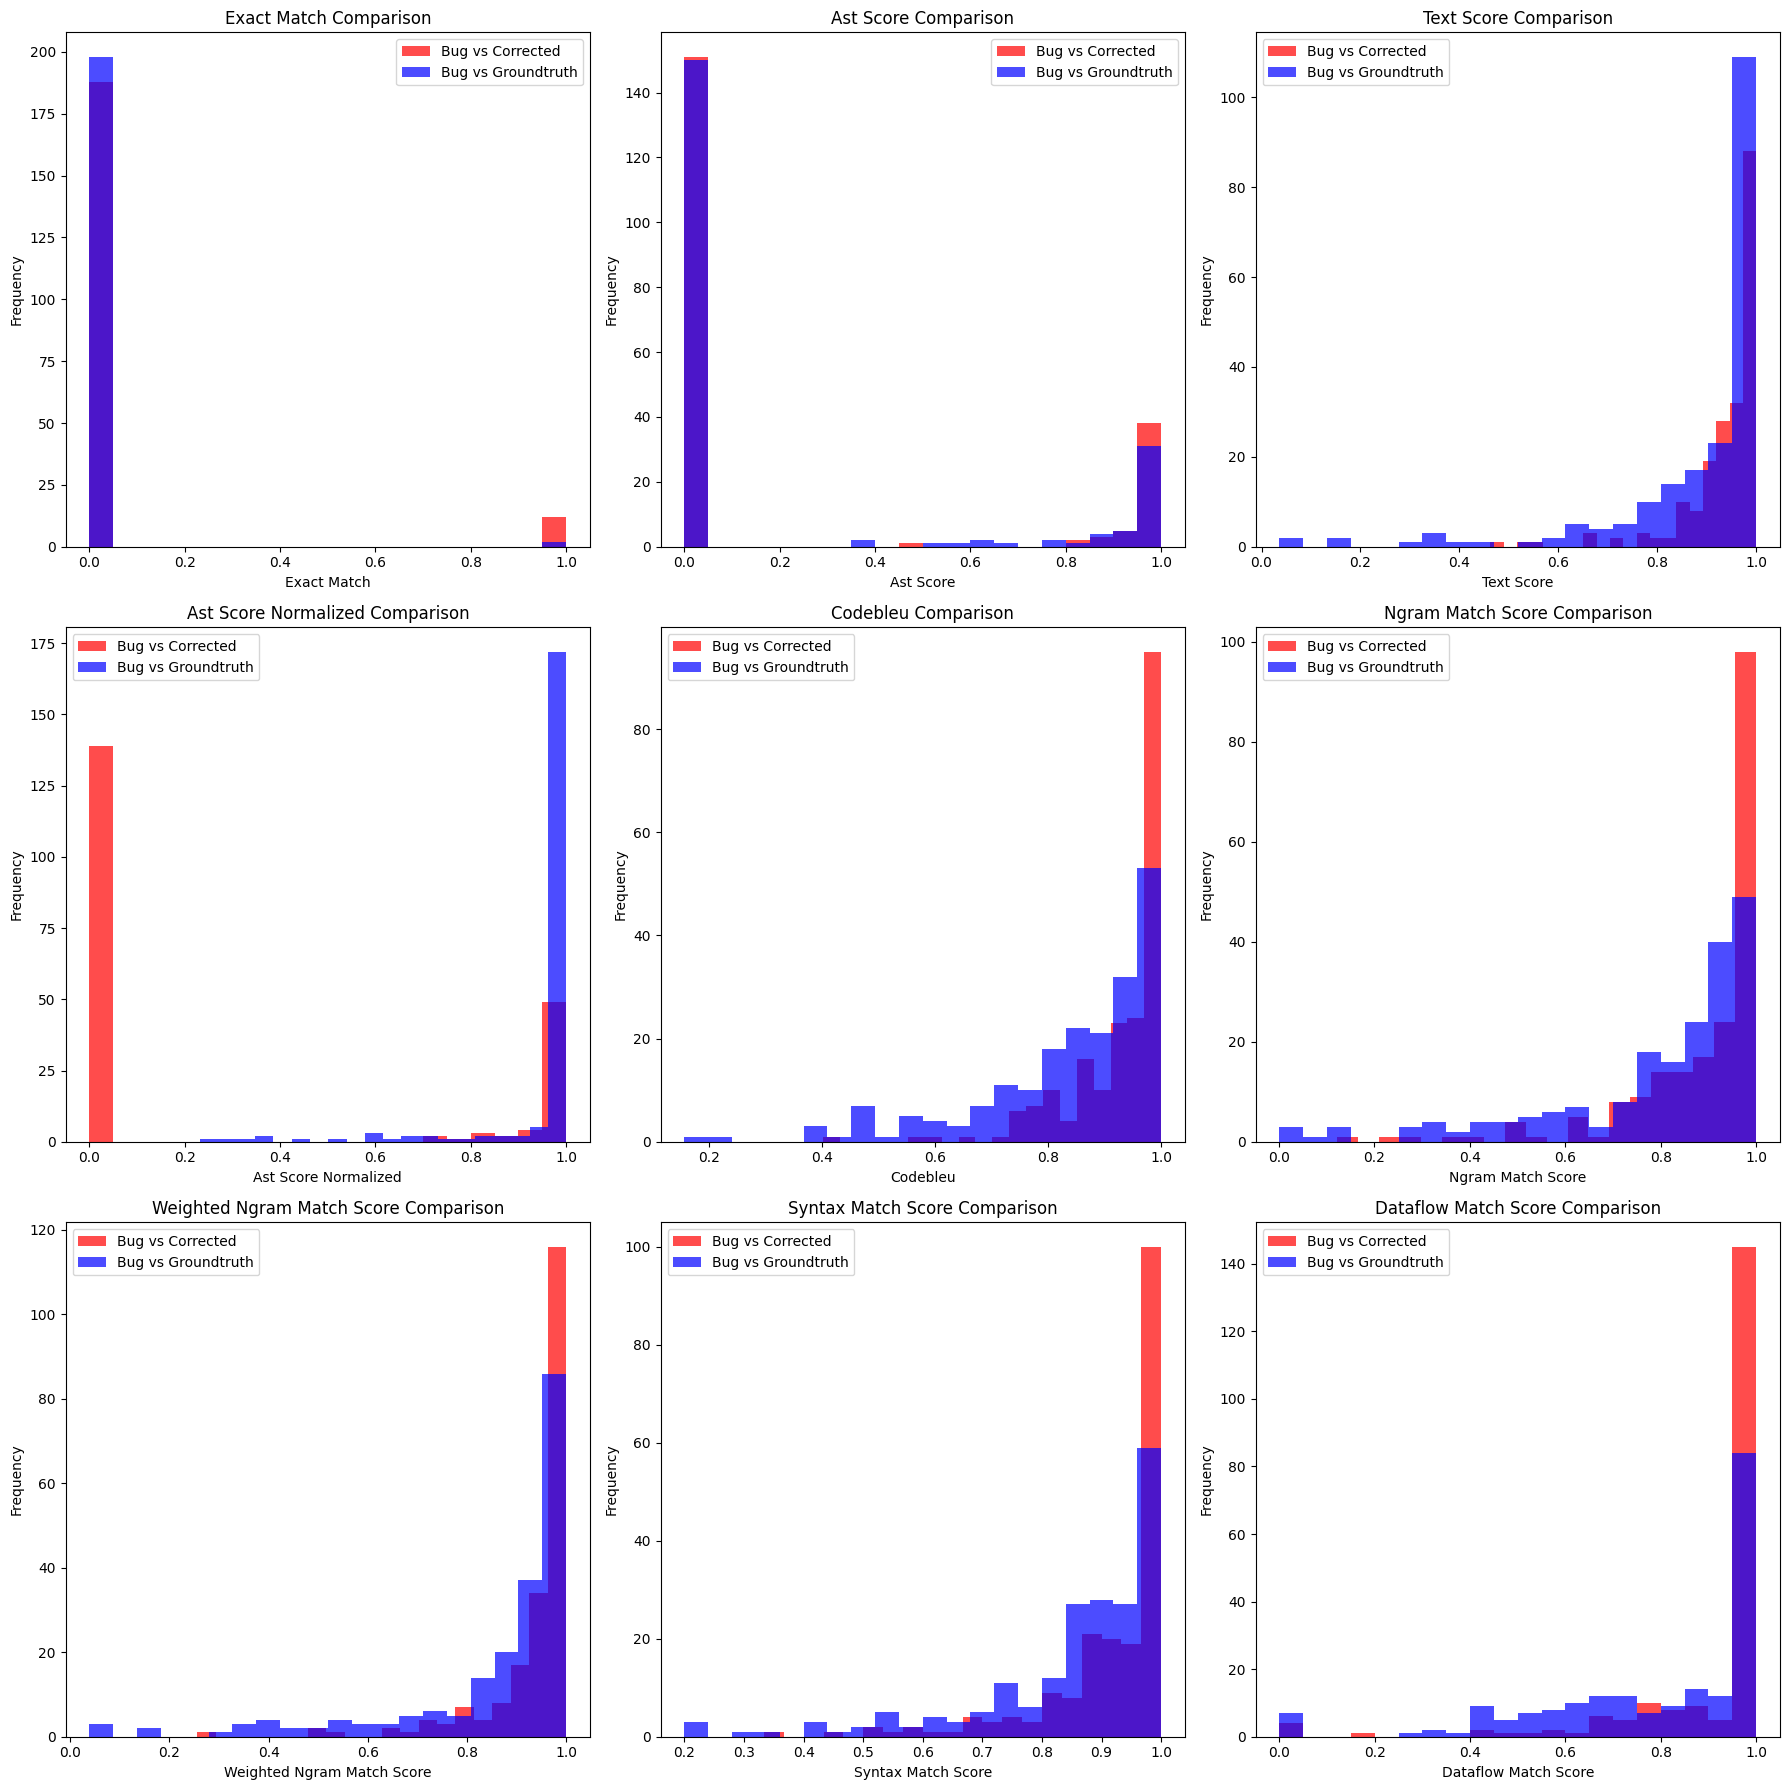

=== ALL METRICS STATISTICS ===
Exact Match - Bug vs Corrected: mean=0.060, std=0.237
Exact Match - Bug vs Groundtruth: mean=0.010, std=0.099
Ast Score - Bug vs Corrected: mean=0.235, std=0.415
Ast Score - Bug vs Groundtruth: mean=0.224, std=0.397
Text Score - Bug vs Corrected: mean=0.937, std=0.085
Text Score - Bug vs Groundtruth: mean=0.886, std=0.176
Ast Score Normalized - Bug vs Corrected: mean=0.294, std=0.445
Ast Score Normalized - Bug vs Groundtruth: mean=0.955, std=0.137
Codebleu - Bug vs Corrected: mean=0.930, std=0.093
Codebleu - Bug vs Groundtruth: mean=0.837, std=0.161
Ngram Match Score - Bug vs Corrected: mean=0.892, std=0.153
Ngram Match Score - Bug vs Groundtruth: mean=0.791, std=0.226
Weighted Ngram Match Score - Bug vs Corrected: mean=0.938, std=0.104
Weighted Ngram Match Score - Bug vs Groundtruth: mean=0.854, std=0.201
Syntax Match Score - Bug vs Corrected: mean=0.919, std=0.117
Syntax Match Score - Bug vs Groundtruth: mean=0.854, std=0.164
Dataflow Match Score - Bug 

In [25]:
# Call the function with the lists
compare_metrics_versus_bug_histograms(
    prompt_data['before_merge_without_docstrings'], prompt_data['after_merge_without_docstrings'], prompt_data['response_qwen-2.5-coder-32b-instruct'])

In [22]:
from utils.simple_metrics import codebleu
codebleu_scores = codebleu(
    sample_data['before_merge'].iloc[0], sample_data['after_merge'].iloc[0])
print(codebleu_scores)

{'codebleu': 0.6902929241254429, 'ngram_match_score': 0.8105822848596743, 'weighted_ngram_match_score': 0.8163683928454585, 'syntax_match_score': 0.6046511627906976, 'dataflow_match_score': 0.5555555555555556}


In [23]:
codebleu_scores = codebleu(sample_data['before_merge_without_docstrings'].iloc[0],
                           sample_data['after_merge_without_docstrings'].iloc[0])
print(codebleu_scores)

{'codebleu': 0.5727627444937661, 'ngram_match_score': 0.5714392512385289, 'weighted_ngram_match_score': 0.5823287021715529, 'syntax_match_score': 0.6046511627906976, 'dataflow_match_score': 0.5555555555555556}


In [24]:
print(prompt_data['after_merge_without_docstrings'].iloc[0])

    def export_outfitting(self, data: Mapping[str, Any], is_beta: bool) -> None:
        
        modules: Dict[str, Any] = data['lastStarport'].get('modules')
        if not modules:
            logger.debug('modules was None')
            modules = {}

        ships: Dict[str, Any] = data['lastStarport'].get('ships')
        if not ships:
            logger.debug('ships was None')
            ships = {'shipyard_list': {}, 'unavailable_list': []}

        
        
        horizons: bool = is_horizons(
            data['lastStarport'].get('economies', {}),
            modules,
            ships
            )

        to_search: Iterator[Mapping[str, Any]] = filter(
            lambda m: self.MODULE_RE.search(m['name']) and m.get('sku') in (None, HORIZ_SKU) and
            m['name'] != 'Int_PlanetApproachSuite',
            modules.values()
        )

        outfitting: List[str] = sorted(
            self.MODULE_RE.sub(lambda match: match.group(0).capitalize(), mod['name'].lower()) f

In [23]:
print(prompt_data['response_gpt-4o'].iloc[0])

def export_outfitting(self, data: Mapping[str, Any], is_beta: bool) -> None:
    
    modules: Dict[str, Any] = {mod['name']: mod for mod in data['lastStarport'].get('modules', [])}

    
    
    horizons: bool = is_horizons(
        data['lastStarport'].get('economies', {}),
        modules,
        data['lastStarport'].get('ships', {'shipyard_list': {}, 'unavailable_list': []})
        )

    to_search: Iterator[Mapping[str, Any]] = filter(
        lambda m: self.MODULE_RE.search(m['name']) and m.get('sku') in (None, HORIZ_SKU) and
        m['name'] != 'Int_PlanetApproachSuite',
        modules.values()
    )

    outfitting: List[str] = sorted(
        self.MODULE_RE.sub(lambda match: match.group(0).capitalize(), mod['name'].lower()) for mod in to_search
    )
    
    if outfitting and self.outfitting != (horizons, outfitting):
        self.send(data['commander']['name'], {
            '$schemaRef': f'https://eddn.edcd.io/schemas/outfitting/2{"/test" if is_beta else ""}',
        